# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('etau_tree', {'root_raw/et18_raw/ggH_bbtt*.root', 'root_raw/et18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('etau_tree', 'root_raw/et17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('etau_tree',  {'root_raw/et17_raw/ggH_bbtt*.root', 'root_raw/et17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('etau_tree', 'root_raw/et17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('etau_tree', 'root_raw/et17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('etau_tree', 'root_raw/et16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('etau_tree', {'root_raw/et16_raw/ggH_bbtt*.root', 'root_raw/et16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('etau_tree', 'root_raw/et16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('etau_tree', 'root_raw/et16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 1b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.2770 && bpt_deepflavour_2<0')
    files17[i] = files17[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3033 && bpt_deepflavour_2<0')
    files16[i] = files16[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3093 && bpt_deepflavour_2<0')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
myele = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((myele+mytau+mymet).Pt(),(myele+mytau+mymet).Eta(),(myele+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepflavour_1,beta_deepflavour_1,bphi_deepflavour_1,bm_deepflavour_1)'
m_btt = '(mytt+myb1).M()'
m_b1ele = '(myele+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(myele,mytau)'
dR_b1ele = 'ROOT::Math::VectorUtil::DeltaR(myele,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'

# define transverse masses mT and D_zeta
mT_ele = 'sqrt(pow(myele.Pt()+mymet.Pt(),2)-pow(myele.Px()+mymet.Px(),2)-pow(myele.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(myele.Px()/myele.Pt()+mytau.Px()/mytau.Pt(),2)+pow(myele.Py()/myele.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(myele.Px()/myele.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(myele.Py()/myele.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(myele.Px()+mytau.Px())*x_zeta+(myele.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files17[i] = files17[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files16[i] = files16[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 ele+tau trigger requirements
trigger32_18 = '(passEle32 && pt_1>33 && matchEle32_1 && filterEle32_1)'
trigger35_18 = '(passEle35 && pt_1>33 && matchEle35_1 && filterEle35_1)'
trigger2430_18 = '(passEle24Tau30 && matchEle24Tau30_1 && filterEle24Tau30_1 && matchEle24Tau30_2 && filterEle24Tau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'
trigger2430HPS_18 = '(passEle24HPSTau30 && matchEle24HPSTau30_1 && filterEle24HPSTau30_1 && matchEle24HPSTau30_2 && filterEle24HPSTau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'
trigger2430HPS_emb_18 = '(matchEmbFilter_Ele24Tau30_1 && matchEmbFilter_Ele24Tau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'

trigger_mc_18 = trigger2430HPS_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18
trigger_obs_1_18 = trigger2430_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18
trigger_obs_2_18 = trigger2430HPS_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18
trigger_emb_18 = trigger2430HPS_emb_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSmu_2 && byTightDeepVSe_2')\
    .Filter('dR_tt>0.4')

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) or (gen_match_1==3 && gen_match_2<3)')

files18[1] = files18[1].Filter('gen_match_1==3 && gen_match_2==5')#recontructed taus are gen taus
files18[1] = files18[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files18[2] = files18[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1_18 = files18[0].Filter('run<317509').Filter(trigger_obs_1_18)
obs2_18 = files18[0].Filter('run>=317509').Filter(trigger_obs_2_18)
files18[1] = files18[1].Filter(trigger_mc_18)
files18[2] = files18[2].Filter(trigger_emb_18)
files18[3] = files18[3].Filter(trigger_mc_18)

# QCD region
qcd1_18 = obs1_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2_18 = obs2_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 7 ##########################
# 2017 mu+tau trigger requirements 
trigger32_17 = '(passEle32 && pt_1>28 && matchEle32_1 && filterEle32_1)'
trigger27_17 = '(passEle27 && pt_1>28 && matchEle27_1 && filterEle27_1)'
trigger2430_17 = '(passEle24Tau30 && matchEle24Tau30_1 && filterEle24Tau30_1 && matchEle24Tau30_2 && filterEle24Tau30_2 && pt_1>25 && pt_2>35 && pt_1<28 && fabs(eta_2)<2.1)'
# requirements on embedded
trigger32_emb1_17 = '(fabs(eta_1)<1.479 && passEle32 && pt_1>28 && matchEle32_1 && filterEle32_1)'
trigger27_emb1_17 = '(fabs(eta_1)<1.479 && passEle27 && pt_1>28 && matchEle27_1 && filterEle27_1)'
trigger2430_emb1_17 = '(fabs(eta_1)<1.479 && passEle24Tau30 && pt_1>25 && pt_2>35 && pt_1<28 && fabs(eta_2)<2.1)'
triggersingle_emb2_17 = '(fabs(eta_1)>1.479 && ((pt_1>28 && pt_1<40) or (pt_1>40 && passEle32 && pt_1>28 && matchEle32_1 && filterEle32_1) or (pt_1>40 && passEle27 && pt_1>28 && matchEle27_1 && filterEle27_1)))'
triggercross_emb2_17 = '(fabs(eta_1)>1.479 && pt_1>25 && pt_2>35 && pt_1<28 && fabs(eta_2)<2.1)'

trigger_mc_obs_17 = trigger2430_17 + str(' or ') + trigger32_17 + str(' or ') + trigger27_17
trigger_emb_17 = trigger32_emb1_17 + str(' or ') + trigger27_emb1_17 + str(' or ') + trigger2430_emb1_17 + str(' or ') + triggersingle_emb2_17 + str(' or ') + triggercross_emb2_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSmu_2 && byTightDeepVSe_2')\
    .Filter('dR_tt>0.4')

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) or (gen_match_1==3 && gen_match_2<3)')

files17[1] = files17[1].Filter('gen_match_1==3 && gen_match_2==5')#recontructed taus are gen taus
files17[1] = files17[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files17[2] = files17[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files17[0] = files17[0].Filter(trigger_mc_obs_17)
files17[1] = files17[1].Filter(trigger_mc_obs_17)
files17[2] = files17[2].Filter(trigger_emb_17)
files17[3] = files17[3].Filter(trigger_mc_obs_17)

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 6 ##########################
# 2016 mu+tau trigger requirements
trigger25_16 = '(passEle25 && matchEle25_1 && filterEle25_1 && pt_1>26)'

trigger_all_16 = trigger25_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSmu_2 && byTightDeepVSe_2')\
    .Filter('dR_tt>0.4')

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) or (gen_match_1==3 && gen_match_2<3)')

files16[1] = files16[1].Filter('gen_match_1==3 && gen_match_2==5')#recontructed taus are gen taus
files16[1] = files16[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16)
files16[1] = files16[1].Filter(trigger_all_16)
files16[2] = files16[2].Filter(trigger_all_16)
files16[3] = files16[3].Filter(trigger_all_16)

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 1b events
feature_list = ['pt_1', 'm_btt', 'm_b1ele', 'm_b1tau',\
                'dR_tt', 'dR_b1ele', 'dR_b1tau', 'dR_b1tt',\
                'tt_pt', 'tt_eta', 'mT_ele', 'mT_tau', 'mT_b1', 'Dzeta',\
                'bpt_deepflavour_1']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd1_18 = pd.DataFrame(qcd1_18.AsNumpy(feature_list))
qcd2_18 = pd.DataFrame(qcd2_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18_1.shape: ' + str(qcd1_18.shape))
print('qcd18_2.shape: ' + str(qcd2_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd1_18, qcd2_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (5386, 16)
ZTT18.shape  : (48602, 16)
TT18.shape   : (223554, 16)
qcd18_1.shape: (23400, 16)
qcd18_2.shape: (54428, 16)

sig17.shape  : (7382, 16)
ZTT17.shape  : (51675, 16)
TT17.shape   : (31748, 16)
qcd17.shape  : (47971, 16)

sig16.shape  : (6644, 16)
ZTT16.shape  : (24287, 16)
TT16.shape   : (17773, 16)
qcd16.shape  : (35816, 16)

sig_allyears.shape: (19412, 17)
ZTT_allyears.shape: (124564, 17)
TT_allyears.shape : (273075, 17)
qcd_allyears.shape: (161615, 17)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 2427, random_state = 20)#5732->12.5%->
TT_allyears = TT_allyears.sample(n = 9958, random_state = 20)#23600->51.3%->
qcd_allyears = qcd_allyears.sample(n = 7027, random_state = 20)#16658->36.2%->

# collect all MC as one dataframe, separated from another datafream for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
             pt_1       m_btt     m_b1ele     m_b1tau     dR_tt  dR_b1ele  \
0       34.582008   72.060436   88.482322   71.229010  0.405676  3.096040   
1       35.931614  110.463736   87.666347   66.677582  0.411864  3.083760   
2       57.353619  122.776053   73.588896   52.916211  0.452619  1.746732   
3       44.358688  126.908734   90.214851   59.431668  0.538028  2.785939   
4       42.461380  128.177296   77.826505   74.299454  0.481315  1.429344   
...           ...         ...         ...         ...       ...       ...   
5602    37.257828  309.137375  214.418905   23.894512  3.637762  4.497724   
13543   73.220802  800.827557  117.062832  277.351473  4.352494  1.449143   
39240   53.905960  337.509580  135.424973   99.689096  3.811252  1.772407   
19020   44.880085  140.193526  130.728480   84.651326  0.809147  3.116704   
45778  153.500488  520.531950  192.691712  190.148911  3.192542  3.163798   

       dR_b1tau   dR_b1tt       tt_pt    tt_eta      mT_ele

## Compare input feature distributions between sig and bkg

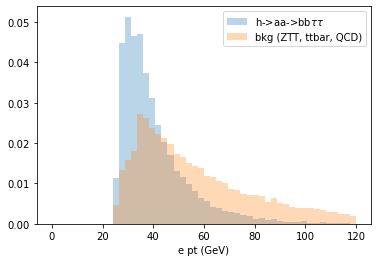

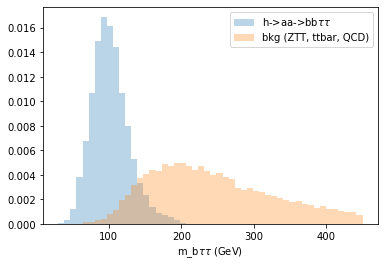

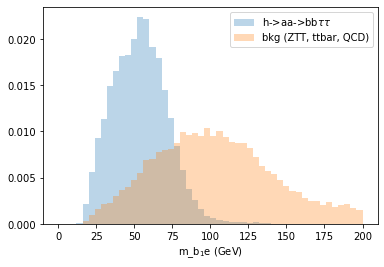

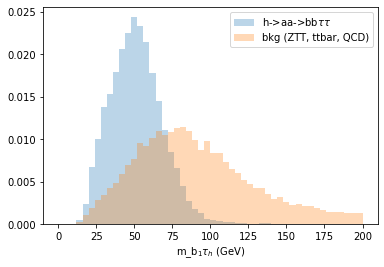

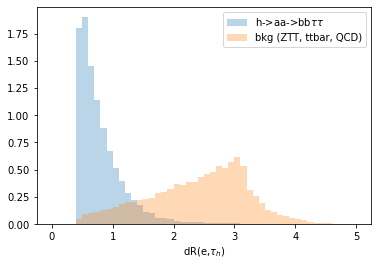

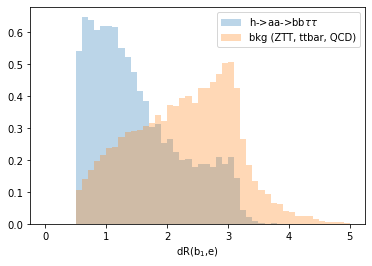

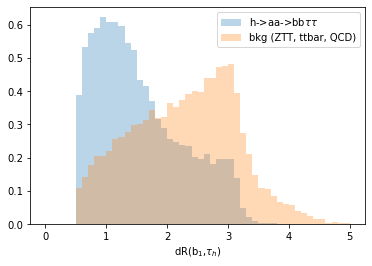

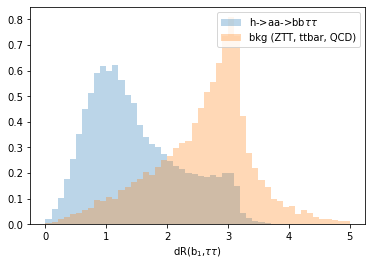

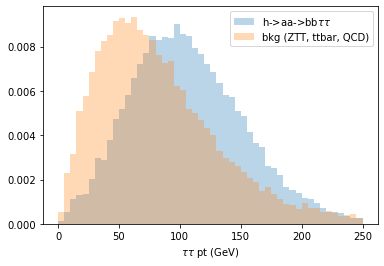

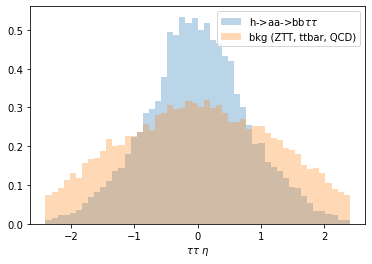

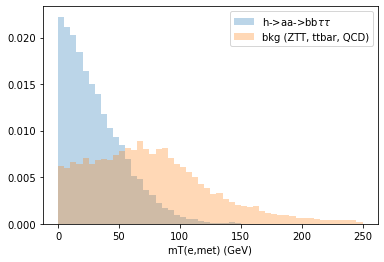

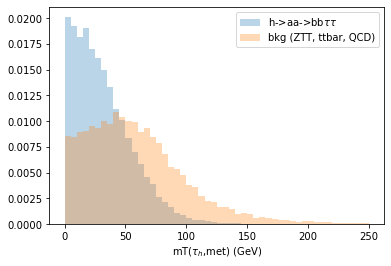

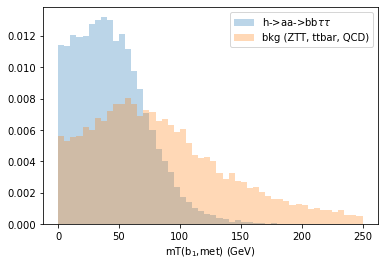

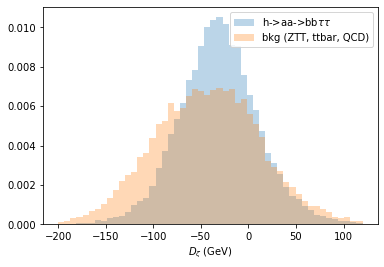

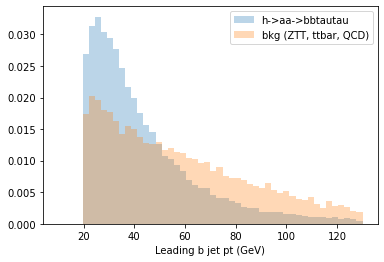

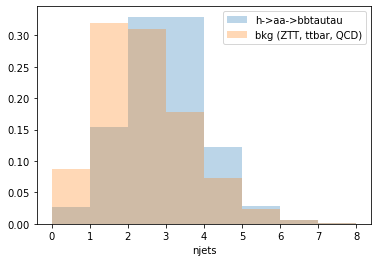

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('e pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$e (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(e,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()

pyplot.hist(sig_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(e,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (23294, 16)
Y_train.shape: (23294, 1)
X_val.shape: (7765, 16)
Y_val.shape: (7765, 1)
X_test.shape: (7765, 16)
Y_test.shape: (7765, 1)

Total number of sig/bkg examples: 19412/19412 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 11653/11641 (50.0%/50.0%)
val   : 3871/3894 (49.9%/50.1%)
test  : 3888/3877 (50.1%/49.9%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 25,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 2, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-04-12 12:55:39.414227: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-04-12 12:55:39.414968: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 25, validation_data = (X_val,Y_val), batch_size = 256)

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 1:06 - loss: 0.6795 - accuracy: 0.57 - ETA: 7s - loss: 0.6432 - accuracy: 0.6037 - ETA: 3s - loss: 0.5980 - accuracy: 0.67 - ETA: 2s - loss: 0.5515 - accuracy: 0.72 - ETA: 1s - loss: 0.5084 - accuracy: 0.76 - ETA: 1s - loss: 0.4709 - accuracy: 0.79 - ETA: 0s - loss: 0.4403 - accuracy: 0.80 - ETA: 0s - loss: 0.4125 - accuracy: 0.82 - ETA: 0s - loss: 0.3886 - accuracy: 0.83 - ETA: 0s - loss: 0.3671 - accuracy: 0.84 - ETA: 0s - loss: 0.3476 - accuracy: 0.85 - ETA: 0s - loss: 0.3303 - accuracy: 0.86 - 2s 66us/sample - loss: 0.3287 - accuracy: 0.8654 - val_loss: 0.1305 - val_accuracy: 0.9534
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.92 - ETA: 0s - loss: 0.1628 - accuracy: 0.94 - ETA: 0s - loss: 0.1483 - accuracy: 0.95 - ETA: 0s - loss: 0.1471 - accuracy: 0.95 - ETA: 0s - loss: 0.1426 - accuracy: 0.95 - ETA: 0s - loss: 0.1460 - acc

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 46s - loss: 0.6758 - accuracy: 0.531 - ETA: 4s - loss: 0.6477 - accuracy: 0.580 - ETA: 2s - loss: 0.6219 - accuracy: 0.61 - ETA: 1s - loss: 0.5981 - accuracy: 0.65 - ETA: 1s - loss: 0.5754 - accuracy: 0.67 - ETA: 0s - loss: 0.5561 - accuracy: 0.70 - ETA: 0s - loss: 0.5332 - accuracy: 0.72 - ETA: 0s - loss: 0.5121 - accuracy: 0.74 - ETA: 0s - loss: 0.4915 - accuracy: 0.76 - ETA: 0s - loss: 0.4708 - accuracy: 0.77 - ETA: 0s - loss: 0.4523 - accuracy: 0.78 - 1s 54us/sample - loss: 0.4484 - accuracy: 0.7917 - val_loss: 0.2011 - val_accuracy: 0.9365
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.88 - ETA: 0s - loss: 0.2783 - accuracy: 0.89 - ETA: 0s - loss: 0.2697 - accuracy: 0.89 - ETA: 0s - loss: 0.2583 - accuracy: 0.90 - ETA: 0s - loss: 0.2503 - accuracy: 0.90 - ETA: 0s - loss: 0.2418 - accuracy: 0.91 - ETA: 0s - loss: 0.2329 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 47s - loss: 0.8004 - accuracy: 0.371 - ETA: 4s - loss: 0.6981 - accuracy: 0.480 - ETA: 2s - loss: 0.6473 - accuracy: 0.55 - ETA: 1s - loss: 0.6058 - accuracy: 0.62 - ETA: 1s - loss: 0.5719 - accuracy: 0.67 - ETA: 0s - loss: 0.5413 - accuracy: 0.70 - ETA: 0s - loss: 0.5121 - accuracy: 0.73 - ETA: 0s - loss: 0.4883 - accuracy: 0.75 - ETA: 0s - loss: 0.4640 - accuracy: 0.77 - ETA: 0s - loss: 0.4414 - accuracy: 0.78 - ETA: 0s - loss: 0.4216 - accuracy: 0.79 - ETA: 0s - loss: 0.4043 - accuracy: 0.81 - 1s 57us/sample - loss: 0.4005 - accuracy: 0.8129 - val_loss: 0.1740 - val_accuracy: 0.9354
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.93 - ETA: 0s - loss: 0.2045 - accuracy: 0.92 - ETA: 0s - loss: 0.2068 - accuracy: 0.92 - ETA: 0s - loss: 0.2064 - accuracy: 0.92 - ETA: 0s - loss: 0.1994 - accuracy: 0.92 - ETA: 0s - loss: 0.1948 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 44s - loss: 0.7015 - accuracy: 0.550 - ETA: 5s - loss: 0.6260 - accuracy: 0.650 - ETA: 3s - loss: 0.5766 - accuracy: 0.70 - ETA: 1s - loss: 0.5279 - accuracy: 0.74 - ETA: 1s - loss: 0.4880 - accuracy: 0.77 - ETA: 1s - loss: 0.4560 - accuracy: 0.80 - ETA: 0s - loss: 0.4248 - accuracy: 0.81 - ETA: 0s - loss: 0.3994 - accuracy: 0.83 - ETA: 0s - loss: 0.3793 - accuracy: 0.84 - ETA: 0s - loss: 0.3597 - accuracy: 0.85 - ETA: 0s - loss: 0.3438 - accuracy: 0.85 - ETA: 0s - loss: 0.3293 - accuracy: 0.86 - 1s 58us/sample - loss: 0.3147 - accuracy: 0.8728 - val_loss: 0.1233 - val_accuracy: 0.9556
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.92 - ETA: 0s - loss: 0.1592 - accuracy: 0.94 - ETA: 0s - loss: 0.1625 - accuracy: 0.94 - ETA: 0s - loss: 0.1545 - accuracy: 0.94 - ETA: 0s - loss: 0.1522 - accuracy: 0.94 - ETA: 0s - loss: 0.1491 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 44s - loss: 0.7219 - accuracy: 0.492 - ETA: 4s - loss: 0.6776 - accuracy: 0.564 - ETA: 2s - loss: 0.6361 - accuracy: 0.62 - ETA: 1s - loss: 0.5967 - accuracy: 0.67 - ETA: 1s - loss: 0.5598 - accuracy: 0.71 - ETA: 0s - loss: 0.5266 - accuracy: 0.74 - ETA: 0s - loss: 0.4963 - accuracy: 0.76 - ETA: 0s - loss: 0.4703 - accuracy: 0.78 - ETA: 0s - loss: 0.4450 - accuracy: 0.80 - ETA: 0s - loss: 0.4199 - accuracy: 0.81 - ETA: 0s - loss: 0.4011 - accuracy: 0.82 - 1s 54us/sample - loss: 0.3928 - accuracy: 0.8305 - val_loss: 0.1524 - val_accuracy: 0.9478
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.92 - ETA: 0s - loss: 0.1937 - accuracy: 0.93 - ETA: 0s - loss: 0.1816 - accuracy: 0.93 - ETA: 0s - loss: 0.1822 - accuracy: 0.93 - ETA: 0s - loss: 0.1800 - accuracy: 0.93 - ETA: 0s - loss: 0.1764 - accuracy: 0.94 - ETA: 0s - loss: 0.1743 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 45s - loss: 0.7753 - accuracy: 0.543 - ETA: 4s - loss: 0.7046 - accuracy: 0.592 - ETA: 2s - loss: 0.6339 - accuracy: 0.65 - ETA: 1s - loss: 0.5717 - accuracy: 0.70 - ETA: 1s - loss: 0.5304 - accuracy: 0.74 - ETA: 0s - loss: 0.4971 - accuracy: 0.76 - ETA: 0s - loss: 0.4671 - accuracy: 0.78 - ETA: 0s - loss: 0.4434 - accuracy: 0.80 - ETA: 0s - loss: 0.4178 - accuracy: 0.81 - ETA: 0s - loss: 0.3976 - accuracy: 0.83 - ETA: 0s - loss: 0.3779 - accuracy: 0.84 - 1s 54us/sample - loss: 0.3699 - accuracy: 0.8452 - val_loss: 0.1550 - val_accuracy: 0.9518
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.94 - ETA: 0s - loss: 0.1999 - accuracy: 0.93 - ETA: 0s - loss: 0.1898 - accuracy: 0.94 - ETA: 0s - loss: 0.1815 - accuracy: 0.94 - ETA: 0s - loss: 0.1795 - accuracy: 0.94 - ETA: 0s - loss: 0.1717 - accuracy: 0.94 - ETA: 0s - loss: 0.1662 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 44s - loss: 0.6853 - accuracy: 0.550 - ETA: 4s - loss: 0.6475 - accuracy: 0.606 - ETA: 2s - loss: 0.6053 - accuracy: 0.66 - ETA: 1s - loss: 0.5703 - accuracy: 0.70 - ETA: 1s - loss: 0.5373 - accuracy: 0.74 - ETA: 0s - loss: 0.5064 - accuracy: 0.76 - ETA: 0s - loss: 0.4787 - accuracy: 0.78 - ETA: 0s - loss: 0.4526 - accuracy: 0.80 - ETA: 0s - loss: 0.4325 - accuracy: 0.81 - ETA: 0s - loss: 0.4121 - accuracy: 0.82 - ETA: 0s - loss: 0.3931 - accuracy: 0.83 - ETA: 0s - loss: 0.3752 - accuracy: 0.84 - 1s 55us/sample - loss: 0.3730 - accuracy: 0.8442 - val_loss: 0.1472 - val_accuracy: 0.9498
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.93 - ETA: 0s - loss: 0.1861 - accuracy: 0.93 - ETA: 0s - loss: 0.1807 - accuracy: 0.93 - ETA: 0s - loss: 0.1762 - accuracy: 0.94 - ETA: 0s - loss: 0.1695 - accuracy: 0.94 - ETA: 0s - loss: 0.1666 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 44s - loss: 0.6925 - accuracy: 0.578 - ETA: 5s - loss: 0.6302 - accuracy: 0.659 - ETA: 2s - loss: 0.5786 - accuracy: 0.72 - ETA: 1s - loss: 0.5344 - accuracy: 0.76 - ETA: 1s - loss: 0.4976 - accuracy: 0.79 - ETA: 0s - loss: 0.4639 - accuracy: 0.82 - ETA: 0s - loss: 0.4359 - accuracy: 0.83 - ETA: 0s - loss: 0.4094 - accuracy: 0.84 - ETA: 0s - loss: 0.3876 - accuracy: 0.85 - ETA: 0s - loss: 0.3670 - accuracy: 0.86 - ETA: 0s - loss: 0.3493 - accuracy: 0.87 - ETA: 0s - loss: 0.3353 - accuracy: 0.87 - 1s 56us/sample - loss: 0.3274 - accuracy: 0.8821 - val_loss: 0.1300 - val_accuracy: 0.9579
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.93 - ETA: 0s - loss: 0.1536 - accuracy: 0.94 - ETA: 0s - loss: 0.1546 - accuracy: 0.94 - ETA: 0s - loss: 0.1507 - accuracy: 0.94 - ETA: 0s - loss: 0.1417 - accuracy: 0.95 - ETA: 0s - loss: 0.1404 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 44s - loss: 0.6439 - accuracy: 0.550 - ETA: 5s - loss: 0.6155 - accuracy: 0.603 - ETA: 2s - loss: 0.5767 - accuracy: 0.66 - ETA: 1s - loss: 0.5378 - accuracy: 0.71 - ETA: 1s - loss: 0.5056 - accuracy: 0.75 - ETA: 0s - loss: 0.4765 - accuracy: 0.77 - ETA: 0s - loss: 0.4494 - accuracy: 0.79 - ETA: 0s - loss: 0.4238 - accuracy: 0.81 - ETA: 0s - loss: 0.4002 - accuracy: 0.82 - ETA: 0s - loss: 0.3822 - accuracy: 0.83 - ETA: 0s - loss: 0.3652 - accuracy: 0.84 - ETA: 0s - loss: 0.3467 - accuracy: 0.85 - 1s 56us/sample - loss: 0.3404 - accuracy: 0.8573 - val_loss: 0.1400 - val_accuracy: 0.9518
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.96 - ETA: 0s - loss: 0.1549 - accuracy: 0.94 - ETA: 0s - loss: 0.1488 - accuracy: 0.94 - ETA: 0s - loss: 0.1448 - accuracy: 0.95 - ETA: 0s - loss: 0.1440 - accuracy: 0.95 - ETA: 0s - loss: 0.1452 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 44s - loss: 0.6694 - accuracy: 0.546 - ETA: 4s - loss: 0.5804 - accuracy: 0.664 - ETA: 2s - loss: 0.5290 - accuracy: 0.74 - ETA: 1s - loss: 0.4861 - accuracy: 0.79 - ETA: 1s - loss: 0.4472 - accuracy: 0.82 - ETA: 0s - loss: 0.4136 - accuracy: 0.84 - ETA: 0s - loss: 0.3842 - accuracy: 0.85 - ETA: 0s - loss: 0.3621 - accuracy: 0.86 - ETA: 0s - loss: 0.3428 - accuracy: 0.87 - ETA: 0s - loss: 0.3239 - accuracy: 0.88 - ETA: 0s - loss: 0.3071 - accuracy: 0.88 - ETA: 0s - loss: 0.2930 - accuracy: 0.89 - 1s 57us/sample - loss: 0.2840 - accuracy: 0.8976 - val_loss: 0.1111 - val_accuracy: 0.9611
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.94 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1194 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 44s - loss: 0.7649 - accuracy: 0.421 - ETA: 5s - loss: 0.6966 - accuracy: 0.560 - ETA: 3s - loss: 0.6406 - accuracy: 0.64 - ETA: 2s - loss: 0.5969 - accuracy: 0.69 - ETA: 1s - loss: 0.5542 - accuracy: 0.73 - ETA: 1s - loss: 0.5184 - accuracy: 0.76 - ETA: 0s - loss: 0.4889 - accuracy: 0.78 - ETA: 0s - loss: 0.4547 - accuracy: 0.80 - ETA: 0s - loss: 0.4242 - accuracy: 0.82 - ETA: 0s - loss: 0.4043 - accuracy: 0.83 - ETA: 0s - loss: 0.3845 - accuracy: 0.84 - ETA: 0s - loss: 0.3662 - accuracy: 0.85 - ETA: 0s - loss: 0.3492 - accuracy: 0.86 - 1s 58us/sample - loss: 0.3456 - accuracy: 0.8621 - val_loss: 0.1343 - val_accuracy: 0.9544
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1500 - accuracy: 0.94 - ETA: 0s - loss: 0.1480 - accuracy: 0.94 - ETA: 0s - loss: 0.1503 - accuracy: 0.94 - ETA: 0s - loss: 0.1502 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 44s - loss: 0.7182 - accuracy: 0.554 - ETA: 5s - loss: 0.6457 - accuracy: 0.677 - ETA: 3s - loss: 0.5783 - accuracy: 0.75 - ETA: 2s - loss: 0.5255 - accuracy: 0.79 - ETA: 1s - loss: 0.4782 - accuracy: 0.81 - ETA: 1s - loss: 0.4397 - accuracy: 0.83 - ETA: 0s - loss: 0.4144 - accuracy: 0.84 - ETA: 0s - loss: 0.3856 - accuracy: 0.86 - ETA: 0s - loss: 0.3610 - accuracy: 0.87 - ETA: 0s - loss: 0.3405 - accuracy: 0.87 - ETA: 0s - loss: 0.3219 - accuracy: 0.88 - ETA: 0s - loss: 0.3076 - accuracy: 0.89 - ETA: 0s - loss: 0.2931 - accuracy: 0.89 - 1s 60us/sample - loss: 0.2814 - accuracy: 0.9017 - val_loss: 0.1156 - val_accuracy: 0.9620
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.94 - ETA: 0s - loss: 0.1132 - accuracy: 0.96 - ETA: 0s - loss: 0.1200 - accuracy: 0.96 - ETA: 0s - loss: 0.1241 - accuracy: 0.96 - ETA: 0s - loss: 0.1216 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 4/9
23294/23294 [==============================] - ETA: 46s - loss: 0.8086 - accuracy: 0.511 - ETA: 5s - loss: 0.7296 - accuracy: 0.536 - ETA: 3s - loss: 0.6616 - accuracy: 0.59 - ETA: 2s - loss: 0.6063 - accuracy: 0.65 - ETA: 1s - loss: 0.5549 - accuracy: 0.71 - ETA: 1s - loss: 0.5163 - accuracy: 0.74 - ETA: 0s - loss: 0.4818 - accuracy: 0.77 - ETA: 0s - loss: 0.4498 - accuracy: 0.79 - ETA: 0s - loss: 0.4232 - accuracy: 0.81 - ETA: 0s - loss: 0.3974 - accuracy: 0.82 - ETA: 0s - loss: 0.3771 - accuracy: 0.83 - ETA: 0s - loss: 0.3593 - accuracy: 0.84 - ETA: 0s - loss: 0.3415 - accuracy: 0.85 - 1s 59us/sample - loss: 0.3307 - accuracy: 0.8610 - val_loss: 0.1277 - val_accuracy: 0.9571
Epoch 5/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.94 - ETA: 0s - loss: 0.1350 - accuracy: 0.95 - ETA: 0s - loss: 0.1449 - accuracy: 0.95 - ETA: 0s - loss: 0.1439 - accuracy: 0.95 - ETA: 0s - loss: 0.1415 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 4/9
23294/23294 [==============================] - ETA: 45s - loss: 0.7231 - accuracy: 0.464 - ETA: 5s - loss: 0.6429 - accuracy: 0.630 - ETA: 2s - loss: 0.5858 - accuracy: 0.71 - ETA: 1s - loss: 0.5366 - accuracy: 0.76 - ETA: 1s - loss: 0.4938 - accuracy: 0.79 - ETA: 1s - loss: 0.4551 - accuracy: 0.81 - ETA: 0s - loss: 0.4204 - accuracy: 0.83 - ETA: 0s - loss: 0.3907 - accuracy: 0.84 - ETA: 0s - loss: 0.3666 - accuracy: 0.85 - ETA: 0s - loss: 0.3456 - accuracy: 0.86 - ETA: 0s - loss: 0.3267 - accuracy: 0.87 - ETA: 0s - loss: 0.3133 - accuracy: 0.87 - ETA: 0s - loss: 0.2980 - accuracy: 0.88 - 1s 60us/sample - loss: 0.2883 - accuracy: 0.8902 - val_loss: 0.1160 - val_accuracy: 0.9599
Epoch 5/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.94 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1230 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 4/9
23294/23294 [==============================] - ETA: 44s - loss: 0.7061 - accuracy: 0.531 - ETA: 4s - loss: 0.6736 - accuracy: 0.593 - ETA: 2s - loss: 0.6260 - accuracy: 0.65 - ETA: 1s - loss: 0.5913 - accuracy: 0.70 - ETA: 1s - loss: 0.5499 - accuracy: 0.74 - ETA: 0s - loss: 0.5112 - accuracy: 0.77 - ETA: 0s - loss: 0.4793 - accuracy: 0.79 - ETA: 0s - loss: 0.4487 - accuracy: 0.81 - ETA: 0s - loss: 0.4241 - accuracy: 0.82 - ETA: 0s - loss: 0.4005 - accuracy: 0.83 - ETA: 0s - loss: 0.3809 - accuracy: 0.84 - 1s 53us/sample - loss: 0.3772 - accuracy: 0.8507 - val_loss: 0.1411 - val_accuracy: 0.9544
Epoch 5/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.95 - ETA: 0s - loss: 0.1843 - accuracy: 0.94 - ETA: 0s - loss: 0.1707 - accuracy: 0.95 - ETA: 0s - loss: 0.1721 - accuracy: 0.94 - ETA: 0s - loss: 0.1673 - accuracy: 0.94 - ETA: 0s - loss: 0.1648 - accuracy: 0.95 - ETA: 0s - loss: 0.1613 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 4/9
23294/23294 [==============================] - ETA: 44s - loss: 0.6972 - accuracy: 0.574 - ETA: 4s - loss: 0.6394 - accuracy: 0.628 - ETA: 2s - loss: 0.5816 - accuracy: 0.69 - ETA: 1s - loss: 0.5403 - accuracy: 0.74 - ETA: 1s - loss: 0.5022 - accuracy: 0.77 - ETA: 0s - loss: 0.4669 - accuracy: 0.79 - ETA: 0s - loss: 0.4362 - accuracy: 0.81 - ETA: 0s - loss: 0.4102 - accuracy: 0.82 - ETA: 0s - loss: 0.3861 - accuracy: 0.84 - ETA: 0s - loss: 0.3661 - accuracy: 0.85 - ETA: 0s - loss: 0.3475 - accuracy: 0.86 - ETA: 0s - loss: 0.3327 - accuracy: 0.86 - 1s 55us/sample - loss: 0.3308 - accuracy: 0.8682 - val_loss: 0.1268 - val_accuracy: 0.9581
Epoch 5/9
23294/23294 [==============================] - ETA: 0s - loss: 0.2088 - accuracy: 0.93 - ETA: 0s - loss: 0.1666 - accuracy: 0.95 - ETA: 0s - loss: 0.1594 - accuracy: 0.95 - ETA: 0s - loss: 0.1552 - accuracy: 0.95 - ETA: 0s - loss: 0.1510 - accuracy: 0.95 - ETA: 0s - loss: 0.1468 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 10/25
23294/23294 [==============================] - ETA: 47s - loss: 0.7833 - accuracy: 0.488 - ETA: 5s - loss: 0.6865 - accuracy: 0.569 - ETA: 2s - loss: 0.6200 - accuracy: 0.65 - ETA: 2s - loss: 0.5683 - accuracy: 0.71 - ETA: 1s - loss: 0.5261 - accuracy: 0.75 - ETA: 1s - loss: 0.4903 - accuracy: 0.77 - ETA: 0s - loss: 0.4524 - accuracy: 0.80 - ETA: 0s - loss: 0.4254 - accuracy: 0.81 - ETA: 0s - loss: 0.4021 - accuracy: 0.83 - ETA: 0s - loss: 0.3799 - accuracy: 0.84 - ETA: 0s - loss: 0.3613 - accuracy: 0.85 - ETA: 0s - loss: 0.3436 - accuracy: 0.86 - ETA: 0s - loss: 0.3282 - accuracy: 0.86 - 1s 60us/sample - loss: 0.3206 - accuracy: 0.8713 - val_loss: 0.1292 - val_accuracy: 0.9551
Epoch 11/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1303 - accuracy: 0.96 - ETA: 0s - loss: 0.1441 - accuracy: 0.95 - ETA: 0s - loss: 0.1428 - accuracy: 0.95 - ETA: 0s - loss: 0.1376 - accuracy: 0.95 - ETA: 0s - loss: 0.1300 - 

Train on 23294 samples, validate on 7765 samples
Epoch 10/25
23294/23294 [==============================] - ETA: 44s - loss: 0.7011 - accuracy: 0.543 - ETA: 4s - loss: 0.6159 - accuracy: 0.651 - ETA: 2s - loss: 0.5604 - accuracy: 0.72 - ETA: 1s - loss: 0.5135 - accuracy: 0.77 - ETA: 1s - loss: 0.4751 - accuracy: 0.80 - ETA: 0s - loss: 0.4398 - accuracy: 0.82 - ETA: 0s - loss: 0.4101 - accuracy: 0.84 - ETA: 0s - loss: 0.3837 - accuracy: 0.85 - ETA: 0s - loss: 0.3610 - accuracy: 0.86 - ETA: 0s - loss: 0.3419 - accuracy: 0.87 - ETA: 0s - loss: 0.3247 - accuracy: 0.88 - ETA: 0s - loss: 0.3104 - accuracy: 0.88 - 1s 56us/sample - loss: 0.3071 - accuracy: 0.8894 - val_loss: 0.1256 - val_accuracy: 0.9581
Epoch 11/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.93 - ETA: 0s - loss: 0.1565 - accuracy: 0.94 - ETA: 0s - loss: 0.1577 - accuracy: 0.94 - ETA: 0s - loss: 0.1495 - accuracy: 0.94 - ETA: 0s - loss: 0.1484 - accuracy: 0.95 - ETA: 0s - loss: 0.1449 - 

Train on 23294 samples, validate on 7765 samples
Epoch 1/9
23294/23294 [==============================] - ETA: 45s - loss: 0.7204 - accuracy: 0.472 - ETA: 5s - loss: 0.6906 - accuracy: 0.507 - ETA: 2s - loss: 0.6553 - accuracy: 0.57 - ETA: 1s - loss: 0.6148 - accuracy: 0.64 - ETA: 1s - loss: 0.5827 - accuracy: 0.68 - ETA: 0s - loss: 0.5477 - accuracy: 0.72 - ETA: 0s - loss: 0.5148 - accuracy: 0.75 - ETA: 0s - loss: 0.4832 - accuracy: 0.77 - ETA: 0s - loss: 0.4553 - accuracy: 0.79 - ETA: 0s - loss: 0.4301 - accuracy: 0.80 - ETA: 0s - loss: 0.4069 - accuracy: 0.82 - 1s 54us/sample - loss: 0.3991 - accuracy: 0.8253 - val_loss: 0.1492 - val_accuracy: 0.9535
Epoch 2/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.94 - ETA: 0s - loss: 0.1776 - accuracy: 0.94 - ETA: 0s - loss: 0.1740 - accuracy: 0.94 - ETA: 0s - loss: 0.1636 - accuracy: 0.94 - ETA: 0s - loss: 0.1595 - accuracy: 0.94 - ETA: 0s - loss: 0.1583 - accuracy: 0.94 - ETA: 0s - loss: 0.1550 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/9
23294/23294 [==============================] - ETA: 45s - loss: 0.8530 - accuracy: 0.476 - ETA: 4s - loss: 0.7199 - accuracy: 0.577 - ETA: 2s - loss: 0.6299 - accuracy: 0.65 - ETA: 1s - loss: 0.5597 - accuracy: 0.71 - ETA: 1s - loss: 0.4980 - accuracy: 0.75 - ETA: 0s - loss: 0.4580 - accuracy: 0.78 - ETA: 0s - loss: 0.4272 - accuracy: 0.80 - ETA: 0s - loss: 0.3989 - accuracy: 0.82 - ETA: 0s - loss: 0.3777 - accuracy: 0.83 - ETA: 0s - loss: 0.3542 - accuracy: 0.84 - ETA: 0s - loss: 0.3359 - accuracy: 0.85 - ETA: 0s - loss: 0.3189 - accuracy: 0.86 - 1s 57us/sample - loss: 0.3116 - accuracy: 0.8681 - val_loss: 0.1195 - val_accuracy: 0.9602
Epoch 2/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.95 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - ETA: 0s - loss: 0.1468 - accuracy: 0.95 - ETA: 0s - loss: 0.1418 - accuracy: 0.95 - ETA: 0s - loss: 0.1406 - accuracy: 0.95 - ETA: 0s - loss: 0.1386 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/9
23294/23294 [==============================] - ETA: 45s - loss: 0.6819 - accuracy: 0.546 - ETA: 5s - loss: 0.6490 - accuracy: 0.593 - ETA: 2s - loss: 0.6136 - accuracy: 0.65 - ETA: 1s - loss: 0.5783 - accuracy: 0.70 - ETA: 1s - loss: 0.5453 - accuracy: 0.74 - ETA: 0s - loss: 0.5167 - accuracy: 0.77 - ETA: 0s - loss: 0.4895 - accuracy: 0.79 - ETA: 0s - loss: 0.4639 - accuracy: 0.80 - ETA: 0s - loss: 0.4375 - accuracy: 0.82 - ETA: 0s - loss: 0.4179 - accuracy: 0.83 - ETA: 0s - loss: 0.3984 - accuracy: 0.84 - ETA: 0s - loss: 0.3812 - accuracy: 0.85 - 1s 55us/sample - loss: 0.3787 - accuracy: 0.8527 - val_loss: 0.1547 - val_accuracy: 0.9529
Epoch 2/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.94 - ETA: 0s - loss: 0.1773 - accuracy: 0.94 - ETA: 0s - loss: 0.1719 - accuracy: 0.94 - ETA: 0s - loss: 0.1639 - accuracy: 0.94 - ETA: 0s - loss: 0.1604 - accuracy: 0.94 - ETA: 0s - loss: 0.1576 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/9
23294/23294 [==============================] - ETA: 45s - loss: 0.7368 - accuracy: 0.546 - ETA: 4s - loss: 0.6389 - accuracy: 0.650 - ETA: 2s - loss: 0.5736 - accuracy: 0.71 - ETA: 1s - loss: 0.5262 - accuracy: 0.75 - ETA: 1s - loss: 0.4845 - accuracy: 0.78 - ETA: 0s - loss: 0.4507 - accuracy: 0.80 - ETA: 0s - loss: 0.4195 - accuracy: 0.82 - ETA: 0s - loss: 0.3940 - accuracy: 0.83 - ETA: 0s - loss: 0.3741 - accuracy: 0.84 - ETA: 0s - loss: 0.3530 - accuracy: 0.85 - ETA: 0s - loss: 0.3355 - accuracy: 0.86 - 1s 54us/sample - loss: 0.3294 - accuracy: 0.8702 - val_loss: 0.1358 - val_accuracy: 0.9556
Epoch 2/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.94 - ETA: 0s - loss: 0.1635 - accuracy: 0.95 - ETA: 0s - loss: 0.1608 - accuracy: 0.94 - ETA: 0s - loss: 0.1530 - accuracy: 0.95 - ETA: 0s - loss: 0.1511 - accuracy: 0.95 - ETA: 0s - loss: 0.1487 - accuracy: 0.95 - ETA: 0s - loss: 0.1459 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/9
23294/23294 [==============================] - ETA: 45s - loss: 0.7532 - accuracy: 0.562 - ETA: 5s - loss: 0.6575 - accuracy: 0.641 - ETA: 2s - loss: 0.5926 - accuracy: 0.70 - ETA: 1s - loss: 0.5414 - accuracy: 0.75 - ETA: 1s - loss: 0.5025 - accuracy: 0.77 - ETA: 0s - loss: 0.4712 - accuracy: 0.79 - ETA: 0s - loss: 0.4440 - accuracy: 0.81 - ETA: 0s - loss: 0.4166 - accuracy: 0.83 - ETA: 0s - loss: 0.3920 - accuracy: 0.84 - ETA: 0s - loss: 0.3706 - accuracy: 0.85 - ETA: 0s - loss: 0.3524 - accuracy: 0.86 - ETA: 0s - loss: 0.3360 - accuracy: 0.86 - 1s 56us/sample - loss: 0.3300 - accuracy: 0.8726 - val_loss: 0.1303 - val_accuracy: 0.9552
Epoch 2/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.94 - ETA: 0s - loss: 0.1790 - accuracy: 0.93 - ETA: 0s - loss: 0.1638 - accuracy: 0.94 - ETA: 0s - loss: 0.1582 - accuracy: 0.94 - ETA: 0s - loss: 0.1525 - accuracy: 0.94 - ETA: 0s - loss: 0.1506 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/9
23294/23294 [==============================] - ETA: 45s - loss: 0.7301 - accuracy: 0.441 - ETA: 5s - loss: 0.6792 - accuracy: 0.536 - ETA: 2s - loss: 0.6259 - accuracy: 0.62 - ETA: 1s - loss: 0.5793 - accuracy: 0.69 - ETA: 1s - loss: 0.5388 - accuracy: 0.73 - ETA: 0s - loss: 0.5014 - accuracy: 0.77 - ETA: 0s - loss: 0.4678 - accuracy: 0.79 - ETA: 0s - loss: 0.4380 - accuracy: 0.81 - ETA: 0s - loss: 0.4128 - accuracy: 0.82 - ETA: 0s - loss: 0.3906 - accuracy: 0.84 - ETA: 0s - loss: 0.3692 - accuracy: 0.85 - ETA: 0s - loss: 0.3520 - accuracy: 0.85 - 1s 56us/sample - loss: 0.3475 - accuracy: 0.8610 - val_loss: 0.1303 - val_accuracy: 0.9570
Epoch 2/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.96 - ETA: 0s - loss: 0.1581 - accuracy: 0.95 - ETA: 0s - loss: 0.1524 - accuracy: 0.95 - ETA: 0s - loss: 0.1470 - accuracy: 0.95 - ETA: 0s - loss: 0.1492 - accuracy: 0.95 - ETA: 0s - loss: 0.1469 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 10/25
23294/23294 [==============================] - ETA: 45s - loss: 0.7419 - accuracy: 0.519 - ETA: 5s - loss: 0.6658 - accuracy: 0.598 - ETA: 2s - loss: 0.6086 - accuracy: 0.68 - ETA: 1s - loss: 0.5676 - accuracy: 0.72 - ETA: 1s - loss: 0.5286 - accuracy: 0.76 - ETA: 0s - loss: 0.4979 - accuracy: 0.78 - ETA: 0s - loss: 0.4699 - accuracy: 0.80 - ETA: 0s - loss: 0.4445 - accuracy: 0.82 - ETA: 0s - loss: 0.4213 - accuracy: 0.83 - ETA: 0s - loss: 0.4015 - accuracy: 0.84 - ETA: 0s - loss: 0.3832 - accuracy: 0.85 - ETA: 0s - loss: 0.3658 - accuracy: 0.86 - 1s 55us/sample - loss: 0.3638 - accuracy: 0.8634 - val_loss: 0.1495 - val_accuracy: 0.9524
Epoch 11/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.93 - ETA: 0s - loss: 0.1731 - accuracy: 0.94 - ETA: 0s - loss: 0.1666 - accuracy: 0.94 - ETA: 0s - loss: 0.1619 - accuracy: 0.94 - ETA: 0s - loss: 0.1577 - accuracy: 0.95 - ETA: 0s - loss: 0.1535 - 

Train on 23294 samples, validate on 7765 samples
Epoch 10/25
23294/23294 [==============================] - ETA: 45s - loss: 0.7899 - accuracy: 0.460 - ETA: 5s - loss: 0.6952 - accuracy: 0.571 - ETA: 2s - loss: 0.6211 - accuracy: 0.65 - ETA: 1s - loss: 0.5618 - accuracy: 0.72 - ETA: 1s - loss: 0.5120 - accuracy: 0.76 - ETA: 0s - loss: 0.4710 - accuracy: 0.79 - ETA: 0s - loss: 0.4358 - accuracy: 0.81 - ETA: 0s - loss: 0.4042 - accuracy: 0.83 - ETA: 0s - loss: 0.3774 - accuracy: 0.84 - ETA: 0s - loss: 0.3519 - accuracy: 0.85 - ETA: 0s - loss: 0.3335 - accuracy: 0.86 - 1s 55us/sample - loss: 0.3196 - accuracy: 0.8729 - val_loss: 0.1214 - val_accuracy: 0.9590
Epoch 11/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.93 - ETA: 0s - loss: 0.1568 - accuracy: 0.94 - ETA: 0s - loss: 0.1439 - accuracy: 0.95 - ETA: 0s - loss: 0.1454 - accuracy: 0.95 - ETA: 0s - loss: 0.1407 - accuracy: 0.95 - ETA: 0s - loss: 0.1387 - accuracy: 0.95 - ETA: 0s - loss: 0.1372 - 

Train on 23294 samples, validate on 7765 samples
Epoch 1/25
23294/23294 [==============================] - ETA: 45s - loss: 0.8011 - accuracy: 0.398 - ETA: 5s - loss: 0.7503 - accuracy: 0.479 - ETA: 2s - loss: 0.7032 - accuracy: 0.55 - ETA: 1s - loss: 0.6537 - accuracy: 0.62 - ETA: 1s - loss: 0.6150 - accuracy: 0.66 - ETA: 0s - loss: 0.5790 - accuracy: 0.70 - ETA: 0s - loss: 0.5461 - accuracy: 0.73 - ETA: 0s - loss: 0.5145 - accuracy: 0.75 - ETA: 0s - loss: 0.4862 - accuracy: 0.77 - ETA: 0s - loss: 0.4613 - accuracy: 0.79 - ETA: 0s - loss: 0.4403 - accuracy: 0.80 - 1s 55us/sample - loss: 0.4211 - accuracy: 0.8166 - val_loss: 0.1698 - val_accuracy: 0.9448
Epoch 2/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.92 - ETA: 0s - loss: 0.2133 - accuracy: 0.92 - ETA: 0s - loss: 0.2017 - accuracy: 0.93 - ETA: 0s - loss: 0.1935 - accuracy: 0.93 - ETA: 0s - loss: 0.1880 - accuracy: 0.93 - ETA: 0s - loss: 0.1818 - accuracy: 0.93 - ETA: 0s - loss: 0.1795 - ac

Train on 23294 samples, validate on 7765 samples
Epoch 1/25
23294/23294 [==============================] - ETA: 45s - loss: 0.8575 - accuracy: 0.418 - ETA: 4s - loss: 0.7622 - accuracy: 0.509 - ETA: 2s - loss: 0.6943 - accuracy: 0.59 - ETA: 1s - loss: 0.6382 - accuracy: 0.66 - ETA: 1s - loss: 0.5898 - accuracy: 0.71 - ETA: 0s - loss: 0.5479 - accuracy: 0.75 - ETA: 0s - loss: 0.5052 - accuracy: 0.78 - ETA: 0s - loss: 0.4708 - accuracy: 0.80 - ETA: 0s - loss: 0.4421 - accuracy: 0.81 - ETA: 0s - loss: 0.4154 - accuracy: 0.83 - ETA: 0s - loss: 0.3948 - accuracy: 0.84 - ETA: 0s - loss: 0.3755 - accuracy: 0.85 - 1s 56us/sample - loss: 0.3736 - accuracy: 0.8519 - val_loss: 0.1379 - val_accuracy: 0.9549
Epoch 2/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.96 - ETA: 0s - loss: 0.1497 - accuracy: 0.95 - ETA: 0s - loss: 0.1529 - accuracy: 0.94 - ETA: 0s - loss: 0.1506 - accuracy: 0.95 - ETA: 0s - loss: 0.1465 - accuracy: 0.95 - ETA: 0s - loss: 0.1423 - ac

Epoch 14/25
23294/23294 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.97 - ETA: 0s - loss: 0.0702 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0789 - accuracy: 0.97 - ETA: 0s - loss: 0.0788 - accuracy: 0.97 - ETA: 0s - loss: 0.0781 - accuracy: 0.97 - ETA: 0s - loss: 0.0794 - accuracy: 0.97 - ETA: 0s - loss: 0.0794 - accuracy: 0.97 - 1s 29us/sample - loss: 0.0800 - accuracy: 0.9721 - val_loss: 0.0782 - val_accuracy: 0.9727
Epoch 15/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.96 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0758 - accuracy: 0.97 - ETA: 0s - loss: 0.0824 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - ETA: 0s - loss: 0.0815 - accuracy: 0.97 - ETA: 0s - loss: 0.0797 - accuracy: 

Train on 23294 samples, validate on 7765 samples
Epoch 1/25
23294/23294 [==============================] - ETA: 45s - loss: 0.8443 - accuracy: 0.472 - ETA: 4s - loss: 0.7323 - accuracy: 0.572 - ETA: 2s - loss: 0.6637 - accuracy: 0.62 - ETA: 1s - loss: 0.6052 - accuracy: 0.67 - ETA: 1s - loss: 0.5617 - accuracy: 0.71 - ETA: 0s - loss: 0.5253 - accuracy: 0.73 - ETA: 0s - loss: 0.4969 - accuracy: 0.76 - ETA: 0s - loss: 0.4711 - accuracy: 0.77 - ETA: 0s - loss: 0.4474 - accuracy: 0.79 - ETA: 0s - loss: 0.4288 - accuracy: 0.80 - ETA: 0s - loss: 0.4096 - accuracy: 0.81 - 1s 53us/sample - loss: 0.4074 - accuracy: 0.8169 - val_loss: 0.1723 - val_accuracy: 0.9477
Epoch 2/25
23294/23294 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.89 - ETA: 0s - loss: 0.2251 - accuracy: 0.92 - ETA: 0s - loss: 0.2159 - accuracy: 0.92 - ETA: 0s - loss: 0.2110 - accuracy: 0.92 - ETA: 0s - loss: 0.2072 - accuracy: 0.92 - ETA: 0s - loss: 0.1989 - accuracy: 0.93 - ETA: 0s - loss: 0.1956 - ac

Train on 23294 samples, validate on 7765 samples
Epoch 1/25
23294/23294 [==============================] - ETA: 45s - loss: 0.7159 - accuracy: 0.503 - ETA: 4s - loss: 0.6626 - accuracy: 0.599 - ETA: 2s - loss: 0.6162 - accuracy: 0.65 - ETA: 1s - loss: 0.5715 - accuracy: 0.70 - ETA: 1s - loss: 0.5358 - accuracy: 0.73 - ETA: 0s - loss: 0.5013 - accuracy: 0.76 - ETA: 0s - loss: 0.4729 - accuracy: 0.78 - ETA: 0s - loss: 0.4492 - accuracy: 0.79 - ETA: 0s - loss: 0.4278 - accuracy: 0.81 - ETA: 0s - loss: 0.4083 - accuracy: 0.82 - ETA: 0s - loss: 0.3921 - accuracy: 0.82 - 1s 55us/sample - loss: 0.3770 - accuracy: 0.8380 - val_loss: 0.1557 - val_accuracy: 0.9475
Epoch 2/25
23294/23294 [==============================] - ETA: 0s - loss: 0.2089 - accuracy: 0.94 - ETA: 0s - loss: 0.1964 - accuracy: 0.93 - ETA: 0s - loss: 0.1928 - accuracy: 0.93 - ETA: 0s - loss: 0.1889 - accuracy: 0.93 - ETA: 0s - loss: 0.1819 - accuracy: 0.93 - ETA: 0s - loss: 0.1757 - accuracy: 0.93 - ETA: 0s - loss: 0.1690 - ac

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 45s - loss: 0.8247 - accuracy: 0.511 - ETA: 4s - loss: 0.7176 - accuracy: 0.575 - ETA: 2s - loss: 0.6625 - accuracy: 0.62 - ETA: 1s - loss: 0.6148 - accuracy: 0.67 - ETA: 1s - loss: 0.5773 - accuracy: 0.70 - ETA: 0s - loss: 0.5423 - accuracy: 0.73 - ETA: 0s - loss: 0.5118 - accuracy: 0.75 - ETA: 0s - loss: 0.4866 - accuracy: 0.77 - ETA: 0s - loss: 0.4625 - accuracy: 0.78 - ETA: 0s - loss: 0.4390 - accuracy: 0.80 - 1s 53us/sample - loss: 0.4194 - accuracy: 0.8115 - val_loss: 0.1758 - val_accuracy: 0.9436
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.94 - ETA: 0s - loss: 0.2303 - accuracy: 0.91 - ETA: 0s - loss: 0.2097 - accuracy: 0.92 - ETA: 0s - loss: 0.2090 - accuracy: 0.92 - ETA: 0s - loss: 0.2082 - accuracy: 0.92 - ETA: 0s - loss: 0.2104 - accuracy: 0.92 - ETA: 0s - loss: 0.2076 - accuracy: 0.92 - ETA: 0s - loss: 0.2057 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 45s - loss: 0.8093 - accuracy: 0.484 - ETA: 4s - loss: 0.7454 - accuracy: 0.525 - ETA: 2s - loss: 0.7060 - accuracy: 0.56 - ETA: 1s - loss: 0.6698 - accuracy: 0.60 - ETA: 1s - loss: 0.6466 - accuracy: 0.62 - ETA: 0s - loss: 0.6185 - accuracy: 0.65 - ETA: 0s - loss: 0.5926 - accuracy: 0.67 - ETA: 0s - loss: 0.5676 - accuracy: 0.69 - ETA: 0s - loss: 0.5460 - accuracy: 0.71 - ETA: 0s - loss: 0.5244 - accuracy: 0.73 - ETA: 0s - loss: 0.5031 - accuracy: 0.74 - ETA: 0s - loss: 0.4846 - accuracy: 0.76 - 1s 57us/sample - loss: 0.4803 - accuracy: 0.7638 - val_loss: 0.2028 - val_accuracy: 0.9381
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.86 - ETA: 0s - loss: 0.2746 - accuracy: 0.89 - ETA: 0s - loss: 0.2555 - accuracy: 0.90 - ETA: 0s - loss: 0.2583 - accuracy: 0.90 - ETA: 0s - loss: 0.2505 - accuracy: 0.90 - ETA: 0s - loss: 0.2454 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 45s - loss: 0.6700 - accuracy: 0.523 - ETA: 5s - loss: 0.6343 - accuracy: 0.566 - ETA: 2s - loss: 0.5969 - accuracy: 0.61 - ETA: 1s - loss: 0.5739 - accuracy: 0.65 - ETA: 1s - loss: 0.5421 - accuracy: 0.70 - ETA: 0s - loss: 0.5146 - accuracy: 0.73 - ETA: 0s - loss: 0.4889 - accuracy: 0.76 - ETA: 0s - loss: 0.4677 - accuracy: 0.78 - ETA: 0s - loss: 0.4480 - accuracy: 0.79 - ETA: 0s - loss: 0.4257 - accuracy: 0.81 - ETA: 0s - loss: 0.4062 - accuracy: 0.82 - 1s 55us/sample - loss: 0.3928 - accuracy: 0.8347 - val_loss: 0.1681 - val_accuracy: 0.9498
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.92 - ETA: 0s - loss: 0.2023 - accuracy: 0.93 - ETA: 0s - loss: 0.1876 - accuracy: 0.93 - ETA: 0s - loss: 0.1766 - accuracy: 0.94 - ETA: 0s - loss: 0.1708 - accuracy: 0.94 - ETA: 0s - loss: 0.1644 - accuracy: 0.94 - ETA: 0s - loss: 0.1641 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 46s - loss: 0.8689 - accuracy: 0.332 - ETA: 5s - loss: 0.7206 - accuracy: 0.524 - ETA: 2s - loss: 0.6501 - accuracy: 0.62 - ETA: 1s - loss: 0.5904 - accuracy: 0.68 - ETA: 1s - loss: 0.5401 - accuracy: 0.73 - ETA: 0s - loss: 0.4970 - accuracy: 0.77 - ETA: 0s - loss: 0.4606 - accuracy: 0.79 - ETA: 0s - loss: 0.4308 - accuracy: 0.81 - ETA: 0s - loss: 0.4047 - accuracy: 0.82 - ETA: 0s - loss: 0.3832 - accuracy: 0.84 - ETA: 0s - loss: 0.3628 - accuracy: 0.85 - ETA: 0s - loss: 0.3463 - accuracy: 0.85 - 1s 57us/sample - loss: 0.3389 - accuracy: 0.8622 - val_loss: 0.1256 - val_accuracy: 0.9588
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.94 - ETA: 0s - loss: 0.1391 - accuracy: 0.95 - ETA: 0s - loss: 0.1378 - accuracy: 0.95 - ETA: 0s - loss: 0.1380 - accuracy: 0.95 - ETA: 0s - loss: 0.1375 - accuracy: 0.95 - ETA: 0s - loss: 0.1375 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 45s - loss: 0.7102 - accuracy: 0.585 - ETA: 4s - loss: 0.6440 - accuracy: 0.627 - ETA: 2s - loss: 0.6074 - accuracy: 0.66 - ETA: 1s - loss: 0.5719 - accuracy: 0.70 - ETA: 1s - loss: 0.5333 - accuracy: 0.73 - ETA: 0s - loss: 0.5069 - accuracy: 0.76 - ETA: 0s - loss: 0.4789 - accuracy: 0.78 - ETA: 0s - loss: 0.4560 - accuracy: 0.79 - ETA: 0s - loss: 0.4347 - accuracy: 0.80 - ETA: 0s - loss: 0.4157 - accuracy: 0.82 - ETA: 0s - loss: 0.3992 - accuracy: 0.82 - ETA: 0s - loss: 0.3861 - accuracy: 0.83 - 1s 56us/sample - loss: 0.3842 - accuracy: 0.8376 - val_loss: 0.1569 - val_accuracy: 0.9508
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.92 - ETA: 0s - loss: 0.2109 - accuracy: 0.93 - ETA: 0s - loss: 0.1998 - accuracy: 0.93 - ETA: 0s - loss: 0.1944 - accuracy: 0.93 - ETA: 0s - loss: 0.1886 - accuracy: 0.93 - ETA: 0s - loss: 0.1839 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 45s - loss: 0.7491 - accuracy: 0.503 - ETA: 5s - loss: 0.6568 - accuracy: 0.610 - ETA: 2s - loss: 0.5961 - accuracy: 0.68 - ETA: 1s - loss: 0.5507 - accuracy: 0.73 - ETA: 1s - loss: 0.5140 - accuracy: 0.76 - ETA: 0s - loss: 0.4797 - accuracy: 0.78 - ETA: 0s - loss: 0.4479 - accuracy: 0.80 - ETA: 0s - loss: 0.4222 - accuracy: 0.82 - ETA: 0s - loss: 0.3995 - accuracy: 0.83 - ETA: 0s - loss: 0.3796 - accuracy: 0.84 - ETA: 0s - loss: 0.3611 - accuracy: 0.85 - ETA: 0s - loss: 0.3460 - accuracy: 0.86 - 1s 56us/sample - loss: 0.3429 - accuracy: 0.8614 - val_loss: 0.1359 - val_accuracy: 0.9544
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1516 - accuracy: 0.95 - ETA: 0s - loss: 0.1819 - accuracy: 0.93 - ETA: 0s - loss: 0.1722 - accuracy: 0.93 - ETA: 0s - loss: 0.1716 - accuracy: 0.93 - ETA: 0s - loss: 0.1692 - accuracy: 0.94 - ETA: 0s - loss: 0.1633 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 45s - loss: 0.7382 - accuracy: 0.507 - ETA: 5s - loss: 0.6458 - accuracy: 0.615 - ETA: 2s - loss: 0.5891 - accuracy: 0.69 - ETA: 1s - loss: 0.5423 - accuracy: 0.74 - ETA: 1s - loss: 0.4971 - accuracy: 0.77 - ETA: 1s - loss: 0.4614 - accuracy: 0.80 - ETA: 0s - loss: 0.4278 - accuracy: 0.82 - ETA: 0s - loss: 0.4035 - accuracy: 0.83 - ETA: 0s - loss: 0.3827 - accuracy: 0.84 - ETA: 0s - loss: 0.3639 - accuracy: 0.85 - ETA: 0s - loss: 0.3481 - accuracy: 0.86 - ETA: 0s - loss: 0.3337 - accuracy: 0.86 - ETA: 0s - loss: 0.3176 - accuracy: 0.87 - 1s 58us/sample - loss: 0.3160 - accuracy: 0.8772 - val_loss: 0.1316 - val_accuracy: 0.9552
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.96 - ETA: 0s - loss: 0.1542 - accuracy: 0.94 - ETA: 0s - loss: 0.1575 - accuracy: 0.94 - ETA: 0s - loss: 0.1530 - accuracy: 0.94 - ETA: 0s - loss: 0.1465 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 45s - loss: 0.6257 - accuracy: 0.613 - ETA: 5s - loss: 0.5988 - accuracy: 0.652 - ETA: 2s - loss: 0.5534 - accuracy: 0.73 - ETA: 1s - loss: 0.5182 - accuracy: 0.77 - ETA: 1s - loss: 0.4823 - accuracy: 0.80 - ETA: 0s - loss: 0.4480 - accuracy: 0.82 - ETA: 0s - loss: 0.4175 - accuracy: 0.84 - ETA: 0s - loss: 0.3938 - accuracy: 0.85 - ETA: 0s - loss: 0.3699 - accuracy: 0.86 - ETA: 0s - loss: 0.3515 - accuracy: 0.87 - ETA: 0s - loss: 0.3333 - accuracy: 0.87 - ETA: 0s - loss: 0.3204 - accuracy: 0.88 - 1s 57us/sample - loss: 0.3088 - accuracy: 0.8878 - val_loss: 0.1244 - val_accuracy: 0.9558
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1446 - accuracy: 0.94 - ETA: 0s - loss: 0.1376 - accuracy: 0.95 - ETA: 0s - loss: 0.1383 - accuracy: 0.95 - ETA: 0s - loss: 0.1342 - accuracy: 0.95 - ETA: 0s - loss: 0.1303 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 45s - loss: 0.7510 - accuracy: 0.531 - ETA: 4s - loss: 0.6703 - accuracy: 0.635 - ETA: 2s - loss: 0.6157 - accuracy: 0.70 - ETA: 1s - loss: 0.5661 - accuracy: 0.74 - ETA: 1s - loss: 0.5274 - accuracy: 0.77 - ETA: 0s - loss: 0.4972 - accuracy: 0.79 - ETA: 0s - loss: 0.4655 - accuracy: 0.81 - ETA: 0s - loss: 0.4361 - accuracy: 0.83 - ETA: 0s - loss: 0.4088 - accuracy: 0.84 - ETA: 0s - loss: 0.3874 - accuracy: 0.85 - ETA: 0s - loss: 0.3698 - accuracy: 0.86 - 1s 55us/sample - loss: 0.3596 - accuracy: 0.8676 - val_loss: 0.1423 - val_accuracy: 0.9575
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.92 - ETA: 0s - loss: 0.1735 - accuracy: 0.94 - ETA: 0s - loss: 0.1690 - accuracy: 0.94 - ETA: 0s - loss: 0.1666 - accuracy: 0.94 - ETA: 0s - loss: 0.1614 - accuracy: 0.94 - ETA: 0s - loss: 0.1588 - accuracy: 0.94 - ETA: 0s - loss: 0.1570 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 45s - loss: 0.7565 - accuracy: 0.593 - ETA: 4s - loss: 0.6901 - accuracy: 0.634 - ETA: 2s - loss: 0.6253 - accuracy: 0.69 - ETA: 1s - loss: 0.5715 - accuracy: 0.74 - ETA: 1s - loss: 0.5242 - accuracy: 0.77 - ETA: 0s - loss: 0.4912 - accuracy: 0.80 - ETA: 0s - loss: 0.4600 - accuracy: 0.81 - ETA: 0s - loss: 0.4335 - accuracy: 0.83 - ETA: 0s - loss: 0.4093 - accuracy: 0.84 - ETA: 0s - loss: 0.3895 - accuracy: 0.85 - ETA: 0s - loss: 0.3728 - accuracy: 0.85 - ETA: 0s - loss: 0.3602 - accuracy: 0.86 - 1s 56us/sample - loss: 0.3583 - accuracy: 0.8653 - val_loss: 0.1446 - val_accuracy: 0.9524
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.94 - ETA: 0s - loss: 0.1860 - accuracy: 0.94 - ETA: 0s - loss: 0.1798 - accuracy: 0.94 - ETA: 0s - loss: 0.1745 - accuracy: 0.94 - ETA: 0s - loss: 0.1709 - accuracy: 0.94 - ETA: 0s - loss: 0.1672 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 45s - loss: 0.8039 - accuracy: 0.394 - ETA: 4s - loss: 0.7146 - accuracy: 0.494 - ETA: 2s - loss: 0.6715 - accuracy: 0.56 - ETA: 1s - loss: 0.6325 - accuracy: 0.62 - ETA: 1s - loss: 0.5928 - accuracy: 0.67 - ETA: 0s - loss: 0.5560 - accuracy: 0.71 - ETA: 0s - loss: 0.5227 - accuracy: 0.74 - ETA: 0s - loss: 0.4919 - accuracy: 0.76 - ETA: 0s - loss: 0.4654 - accuracy: 0.78 - ETA: 0s - loss: 0.4431 - accuracy: 0.79 - ETA: 0s - loss: 0.4187 - accuracy: 0.81 - 1s 55us/sample - loss: 0.4007 - accuracy: 0.8208 - val_loss: 0.1650 - val_accuracy: 0.9445
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.91 - ETA: 0s - loss: 0.1862 - accuracy: 0.94 - ETA: 0s - loss: 0.1823 - accuracy: 0.94 - ETA: 0s - loss: 0.1761 - accuracy: 0.94 - ETA: 0s - loss: 0.1745 - accuracy: 0.94 - ETA: 0s - loss: 0.1689 - accuracy: 0.94 - ETA: 0s - loss: 0.1669 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/3
23294/23294 [==============================] - ETA: 45s - loss: 0.7641 - accuracy: 0.511 - ETA: 5s - loss: 0.7106 - accuracy: 0.575 - ETA: 2s - loss: 0.6631 - accuracy: 0.61 - ETA: 1s - loss: 0.6210 - accuracy: 0.65 - ETA: 1s - loss: 0.5888 - accuracy: 0.68 - ETA: 0s - loss: 0.5571 - accuracy: 0.71 - ETA: 0s - loss: 0.5278 - accuracy: 0.73 - ETA: 0s - loss: 0.5034 - accuracy: 0.75 - ETA: 0s - loss: 0.4797 - accuracy: 0.77 - ETA: 0s - loss: 0.4584 - accuracy: 0.78 - ETA: 0s - loss: 0.4397 - accuracy: 0.79 - ETA: 0s - loss: 0.4234 - accuracy: 0.80 - 1s 56us/sample - loss: 0.4213 - accuracy: 0.8106 - val_loss: 0.1610 - val_accuracy: 0.9450
Epoch 2/3
23294/23294 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.93 - ETA: 0s - loss: 0.2308 - accuracy: 0.92 - ETA: 0s - loss: 0.2306 - accuracy: 0.92 - ETA: 0s - loss: 0.2250 - accuracy: 0.92 - ETA: 0s - loss: 0.2155 - accuracy: 0.92 - ETA: 0s - loss: 0.2113 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 4/9
23294/23294 [==============================] - ETA: 45s - loss: 0.9168 - accuracy: 0.523 - ETA: 5s - loss: 0.8339 - accuracy: 0.513 - ETA: 2s - loss: 0.7503 - accuracy: 0.55 - ETA: 1s - loss: 0.6809 - accuracy: 0.61 - ETA: 1s - loss: 0.6196 - accuracy: 0.67 - ETA: 0s - loss: 0.5732 - accuracy: 0.71 - ETA: 0s - loss: 0.5318 - accuracy: 0.74 - ETA: 0s - loss: 0.4999 - accuracy: 0.76 - ETA: 0s - loss: 0.4685 - accuracy: 0.78 - ETA: 0s - loss: 0.4412 - accuracy: 0.80 - ETA: 0s - loss: 0.4180 - accuracy: 0.81 - ETA: 0s - loss: 0.3996 - accuracy: 0.82 - 1s 57us/sample - loss: 0.3904 - accuracy: 0.8291 - val_loss: 0.1441 - val_accuracy: 0.9529
Epoch 5/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.94 - ETA: 0s - loss: 0.1804 - accuracy: 0.94 - ETA: 0s - loss: 0.1667 - accuracy: 0.94 - ETA: 0s - loss: 0.1622 - accuracy: 0.94 - ETA: 0s - loss: 0.1595 - accuracy: 0.94 - ETA: 0s - loss: 0.1560 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 4/9
23294/23294 [==============================] - ETA: 45s - loss: 0.7090 - accuracy: 0.574 - ETA: 5s - loss: 0.6734 - accuracy: 0.592 - ETA: 2s - loss: 0.6284 - accuracy: 0.64 - ETA: 1s - loss: 0.5882 - accuracy: 0.69 - ETA: 1s - loss: 0.5510 - accuracy: 0.72 - ETA: 0s - loss: 0.5165 - accuracy: 0.75 - ETA: 0s - loss: 0.4834 - accuracy: 0.77 - ETA: 0s - loss: 0.4560 - accuracy: 0.79 - ETA: 0s - loss: 0.4292 - accuracy: 0.81 - ETA: 0s - loss: 0.4044 - accuracy: 0.82 - ETA: 0s - loss: 0.3847 - accuracy: 0.83 - ETA: 0s - loss: 0.3696 - accuracy: 0.84 - 1s 57us/sample - loss: 0.3609 - accuracy: 0.8466 - val_loss: 0.1391 - val_accuracy: 0.9549
Epoch 5/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.94 - ETA: 0s - loss: 0.1558 - accuracy: 0.94 - ETA: 0s - loss: 0.1539 - accuracy: 0.94 - ETA: 0s - loss: 0.1509 - accuracy: 0.94 - ETA: 0s - loss: 0.1507 - accuracy: 0.94 - ETA: 0s - loss: 0.1506 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 4/9
23294/23294 [==============================] - ETA: 45s - loss: 0.7066 - accuracy: 0.511 - ETA: 5s - loss: 0.6207 - accuracy: 0.664 - ETA: 2s - loss: 0.5683 - accuracy: 0.73 - ETA: 1s - loss: 0.5333 - accuracy: 0.77 - ETA: 1s - loss: 0.4903 - accuracy: 0.80 - ETA: 1s - loss: 0.4574 - accuracy: 0.82 - ETA: 0s - loss: 0.4287 - accuracy: 0.83 - ETA: 0s - loss: 0.4030 - accuracy: 0.85 - ETA: 0s - loss: 0.3805 - accuracy: 0.86 - ETA: 0s - loss: 0.3598 - accuracy: 0.86 - ETA: 0s - loss: 0.3413 - accuracy: 0.87 - ETA: 0s - loss: 0.3249 - accuracy: 0.88 - ETA: 0s - loss: 0.3086 - accuracy: 0.88 - 1s 59us/sample - loss: 0.3055 - accuracy: 0.8909 - val_loss: 0.1197 - val_accuracy: 0.9570
Epoch 5/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.94 - ETA: 0s - loss: 0.1373 - accuracy: 0.95 - ETA: 0s - loss: 0.1385 - accuracy: 0.95 - ETA: 0s - loss: 0.1360 - accuracy: 0.95 - ETA: 0s - loss: 0.1330 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 4/9
23294/23294 [==============================] - ETA: 45s - loss: 0.7860 - accuracy: 0.453 - ETA: 5s - loss: 0.7021 - accuracy: 0.551 - ETA: 2s - loss: 0.6436 - accuracy: 0.62 - ETA: 1s - loss: 0.5925 - accuracy: 0.68 - ETA: 1s - loss: 0.5492 - accuracy: 0.72 - ETA: 0s - loss: 0.5122 - accuracy: 0.75 - ETA: 0s - loss: 0.4806 - accuracy: 0.77 - ETA: 0s - loss: 0.4537 - accuracy: 0.79 - ETA: 0s - loss: 0.4306 - accuracy: 0.80 - ETA: 0s - loss: 0.4102 - accuracy: 0.81 - ETA: 0s - loss: 0.3910 - accuracy: 0.82 - ETA: 0s - loss: 0.3739 - accuracy: 0.83 - 1s 56us/sample - loss: 0.3699 - accuracy: 0.8394 - val_loss: 0.1480 - val_accuracy: 0.9498
Epoch 5/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.94 - ETA: 0s - loss: 0.1886 - accuracy: 0.93 - ETA: 0s - loss: 0.1842 - accuracy: 0.93 - ETA: 0s - loss: 0.1762 - accuracy: 0.93 - ETA: 0s - loss: 0.1747 - accuracy: 0.93 - ETA: 0s - loss: 0.1723 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 10/25
23294/23294 [==============================] - ETA: 45s - loss: 0.7479 - accuracy: 0.558 - ETA: 5s - loss: 0.6377 - accuracy: 0.648 - ETA: 2s - loss: 0.5800 - accuracy: 0.71 - ETA: 1s - loss: 0.5380 - accuracy: 0.74 - ETA: 1s - loss: 0.4927 - accuracy: 0.78 - ETA: 0s - loss: 0.4547 - accuracy: 0.80 - ETA: 0s - loss: 0.4241 - accuracy: 0.82 - ETA: 0s - loss: 0.3933 - accuracy: 0.84 - ETA: 0s - loss: 0.3695 - accuracy: 0.85 - ETA: 0s - loss: 0.3487 - accuracy: 0.86 - ETA: 0s - loss: 0.3303 - accuracy: 0.86 - ETA: 0s - loss: 0.3160 - accuracy: 0.87 - 1s 58us/sample - loss: 0.3066 - accuracy: 0.8803 - val_loss: 0.1205 - val_accuracy: 0.9580
Epoch 11/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.96 - ETA: 0s - loss: 0.1359 - accuracy: 0.95 - ETA: 0s - loss: 0.1378 - accuracy: 0.95 - ETA: 0s - loss: 0.1420 - accuracy: 0.95 - ETA: 0s - loss: 0.1400 - accuracy: 0.95 - ETA: 0s - loss: 0.1398 - 

Train on 23294 samples, validate on 7765 samples
Epoch 10/25
23294/23294 [==============================] - ETA: 45s - loss: 0.6318 - accuracy: 0.660 - ETA: 5s - loss: 0.5674 - accuracy: 0.717 - ETA: 2s - loss: 0.5083 - accuracy: 0.78 - ETA: 1s - loss: 0.4628 - accuracy: 0.81 - ETA: 1s - loss: 0.4245 - accuracy: 0.83 - ETA: 0s - loss: 0.3883 - accuracy: 0.85 - ETA: 0s - loss: 0.3597 - accuracy: 0.86 - ETA: 0s - loss: 0.3362 - accuracy: 0.87 - ETA: 0s - loss: 0.3154 - accuracy: 0.88 - ETA: 0s - loss: 0.2984 - accuracy: 0.89 - ETA: 0s - loss: 0.2874 - accuracy: 0.89 - ETA: 0s - loss: 0.2768 - accuracy: 0.90 - 1s 57us/sample - loss: 0.2728 - accuracy: 0.9018 - val_loss: 0.1166 - val_accuracy: 0.9576
Epoch 11/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.94 - ETA: 0s - loss: 0.1394 - accuracy: 0.94 - ETA: 0s - loss: 0.1477 - accuracy: 0.94 - ETA: 0s - loss: 0.1424 - accuracy: 0.94 - ETA: 0s - loss: 0.1341 - accuracy: 0.95 - ETA: 0s - loss: 0.1356 - 

Train on 23294 samples, validate on 7765 samples
Epoch 1/9
23294/23294 [==============================] - ETA: 45s - loss: 0.7914 - accuracy: 0.449 - ETA: 4s - loss: 0.7140 - accuracy: 0.534 - ETA: 2s - loss: 0.6600 - accuracy: 0.61 - ETA: 1s - loss: 0.6197 - accuracy: 0.66 - ETA: 1s - loss: 0.5841 - accuracy: 0.69 - ETA: 0s - loss: 0.5517 - accuracy: 0.72 - ETA: 0s - loss: 0.5206 - accuracy: 0.74 - ETA: 0s - loss: 0.4977 - accuracy: 0.76 - ETA: 0s - loss: 0.4727 - accuracy: 0.78 - ETA: 0s - loss: 0.4510 - accuracy: 0.79 - ETA: 0s - loss: 0.4308 - accuracy: 0.80 - 1s 53us/sample - loss: 0.4286 - accuracy: 0.8084 - val_loss: 0.1858 - val_accuracy: 0.9440
Epoch 2/9
23294/23294 [==============================] - ETA: 0s - loss: 0.2544 - accuracy: 0.90 - ETA: 0s - loss: 0.2272 - accuracy: 0.92 - ETA: 0s - loss: 0.2162 - accuracy: 0.92 - ETA: 0s - loss: 0.2131 - accuracy: 0.92 - ETA: 0s - loss: 0.2043 - accuracy: 0.92 - ETA: 0s - loss: 0.2017 - accuracy: 0.92 - ETA: 0s - loss: 0.1976 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/9
23294/23294 [==============================] - ETA: 45s - loss: 0.7748 - accuracy: 0.496 - ETA: 5s - loss: 0.6886 - accuracy: 0.578 - ETA: 2s - loss: 0.6335 - accuracy: 0.64 - ETA: 1s - loss: 0.5830 - accuracy: 0.69 - ETA: 1s - loss: 0.5350 - accuracy: 0.74 - ETA: 1s - loss: 0.4990 - accuracy: 0.77 - ETA: 0s - loss: 0.4666 - accuracy: 0.79 - ETA: 0s - loss: 0.4373 - accuracy: 0.81 - ETA: 0s - loss: 0.4129 - accuracy: 0.82 - ETA: 0s - loss: 0.3902 - accuracy: 0.83 - ETA: 0s - loss: 0.3713 - accuracy: 0.84 - ETA: 0s - loss: 0.3536 - accuracy: 0.85 - ETA: 0s - loss: 0.3386 - accuracy: 0.86 - 1s 59us/sample - loss: 0.3312 - accuracy: 0.8653 - val_loss: 0.1212 - val_accuracy: 0.9602
Epoch 2/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.92 - ETA: 0s - loss: 0.1695 - accuracy: 0.93 - ETA: 0s - loss: 0.1569 - accuracy: 0.94 - ETA: 0s - loss: 0.1583 - accuracy: 0.94 - ETA: 0s - loss: 0.1536 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/9
23294/23294 [==============================] - ETA: 46s - loss: 0.8750 - accuracy: 0.472 - ETA: 4s - loss: 0.8024 - accuracy: 0.528 - ETA: 2s - loss: 0.7543 - accuracy: 0.55 - ETA: 1s - loss: 0.6996 - accuracy: 0.60 - ETA: 1s - loss: 0.6536 - accuracy: 0.64 - ETA: 0s - loss: 0.6160 - accuracy: 0.67 - ETA: 0s - loss: 0.5856 - accuracy: 0.70 - ETA: 0s - loss: 0.5543 - accuracy: 0.72 - ETA: 0s - loss: 0.5264 - accuracy: 0.74 - ETA: 0s - loss: 0.4986 - accuracy: 0.76 - ETA: 0s - loss: 0.4745 - accuracy: 0.77 - 1s 55us/sample - loss: 0.4543 - accuracy: 0.7893 - val_loss: 0.1790 - val_accuracy: 0.9451
Epoch 2/9
23294/23294 [==============================] - ETA: 0s - loss: 0.2657 - accuracy: 0.90 - ETA: 0s - loss: 0.2447 - accuracy: 0.91 - ETA: 0s - loss: 0.2352 - accuracy: 0.91 - ETA: 0s - loss: 0.2231 - accuracy: 0.92 - ETA: 0s - loss: 0.2157 - accuracy: 0.92 - ETA: 0s - loss: 0.2135 - accuracy: 0.92 - ETA: 0s - loss: 0.2078 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/9
23294/23294 [==============================] - ETA: 45s - loss: 0.7794 - accuracy: 0.441 - ETA: 4s - loss: 0.7289 - accuracy: 0.514 - ETA: 2s - loss: 0.6755 - accuracy: 0.58 - ETA: 1s - loss: 0.6335 - accuracy: 0.64 - ETA: 1s - loss: 0.5954 - accuracy: 0.69 - ETA: 0s - loss: 0.5611 - accuracy: 0.72 - ETA: 0s - loss: 0.5297 - accuracy: 0.74 - ETA: 0s - loss: 0.5004 - accuracy: 0.76 - ETA: 0s - loss: 0.4753 - accuracy: 0.78 - ETA: 0s - loss: 0.4513 - accuracy: 0.79 - ETA: 0s - loss: 0.4306 - accuracy: 0.81 - 1s 54us/sample - loss: 0.4230 - accuracy: 0.8142 - val_loss: 0.1654 - val_accuracy: 0.9469
Epoch 2/9
23294/23294 [==============================] - ETA: 0s - loss: 0.2264 - accuracy: 0.93 - ETA: 0s - loss: 0.2096 - accuracy: 0.92 - ETA: 0s - loss: 0.1991 - accuracy: 0.93 - ETA: 0s - loss: 0.1891 - accuracy: 0.93 - ETA: 0s - loss: 0.1831 - accuracy: 0.93 - ETA: 0s - loss: 0.1805 - accuracy: 0.93 - ETA: 0s - loss: 0.1745 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/9
23294/23294 [==============================] - ETA: 45s - loss: 0.7602 - accuracy: 0.472 - ETA: 4s - loss: 0.7473 - accuracy: 0.490 - ETA: 2s - loss: 0.6996 - accuracy: 0.55 - ETA: 1s - loss: 0.6618 - accuracy: 0.60 - ETA: 0s - loss: 0.6309 - accuracy: 0.64 - ETA: 0s - loss: 0.6029 - accuracy: 0.67 - ETA: 0s - loss: 0.5782 - accuracy: 0.70 - ETA: 0s - loss: 0.5527 - accuracy: 0.72 - ETA: 0s - loss: 0.5286 - accuracy: 0.74 - ETA: 0s - loss: 0.5062 - accuracy: 0.76 - 1s 51us/sample - loss: 0.5040 - accuracy: 0.7653 - val_loss: 0.2538 - val_accuracy: 0.9278
Epoch 2/9
23294/23294 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.92 - ETA: 0s - loss: 0.2989 - accuracy: 0.90 - ETA: 0s - loss: 0.2859 - accuracy: 0.91 - ETA: 0s - loss: 0.2784 - accuracy: 0.91 - ETA: 0s - loss: 0.2650 - accuracy: 0.91 - ETA: 0s - loss: 0.2597 - accuracy: 0.91 - ETA: 0s - loss: 0.2535 - accuracy: 0.92 - ETA: 0s - loss: 0.2452 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 1/9
23294/23294 [==============================] - ETA: 45s - loss: 0.6858 - accuracy: 0.589 - ETA: 5s - loss: 0.6396 - accuracy: 0.658 - ETA: 2s - loss: 0.5843 - accuracy: 0.71 - ETA: 1s - loss: 0.5400 - accuracy: 0.75 - ETA: 1s - loss: 0.5012 - accuracy: 0.78 - ETA: 0s - loss: 0.4673 - accuracy: 0.80 - ETA: 0s - loss: 0.4388 - accuracy: 0.82 - ETA: 0s - loss: 0.4126 - accuracy: 0.83 - ETA: 0s - loss: 0.3922 - accuracy: 0.84 - ETA: 0s - loss: 0.3717 - accuracy: 0.85 - ETA: 0s - loss: 0.3541 - accuracy: 0.86 - ETA: 0s - loss: 0.3386 - accuracy: 0.87 - 1s 55us/sample - loss: 0.3364 - accuracy: 0.8737 - val_loss: 0.1402 - val_accuracy: 0.9536
Epoch 2/9
23294/23294 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 0.94 - ETA: 0s - loss: 0.1745 - accuracy: 0.93 - ETA: 0s - loss: 0.1666 - accuracy: 0.94 - ETA: 0s - loss: 0.1631 - accuracy: 0.94 - ETA: 0s - loss: 0.1592 - accuracy: 0.94 - ETA: 0s - loss: 0.1585 - accu

Train on 23294 samples, validate on 7765 samples
Epoch 10/25
23294/23294 [==============================] - ETA: 45s - loss: 0.8708 - accuracy: 0.449 - ETA: 5s - loss: 0.7652 - accuracy: 0.521 - ETA: 3s - loss: 0.6927 - accuracy: 0.59 - ETA: 2s - loss: 0.6363 - accuracy: 0.65 - ETA: 1s - loss: 0.5879 - accuracy: 0.69 - ETA: 1s - loss: 0.5450 - accuracy: 0.72 - ETA: 0s - loss: 0.5114 - accuracy: 0.75 - ETA: 0s - loss: 0.4797 - accuracy: 0.77 - ETA: 0s - loss: 0.4505 - accuracy: 0.79 - ETA: 0s - loss: 0.4242 - accuracy: 0.80 - ETA: 0s - loss: 0.4038 - accuracy: 0.82 - ETA: 0s - loss: 0.3855 - accuracy: 0.83 - ETA: 0s - loss: 0.3677 - accuracy: 0.84 - 1s 59us/sample - loss: 0.3592 - accuracy: 0.8462 - val_loss: 0.1324 - val_accuracy: 0.9545
Epoch 11/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.93 - ETA: 0s - loss: 0.1527 - accuracy: 0.95 - ETA: 0s - loss: 0.1673 - accuracy: 0.93 - ETA: 0s - loss: 0.1650 - accuracy: 0.94 - ETA: 0s - loss: 0.1628 - 

Epoch 22/25
23294/23294 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.99 - ETA: 0s - loss: 0.0844 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0860 - accuracy: 0.97 - ETA: 0s - loss: 0.0883 - accuracy: 0.97 - ETA: 0s - loss: 0.0869 - accuracy: 0.97 - ETA: 0s - loss: 0.0879 - accuracy: 0.97 - ETA: 0s - loss: 0.0875 - accuracy: 0.97 - ETA: 0s - loss: 0.0867 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0874 - accuracy: 0.97 - 1s 32us/sample - loss: 0.0870 - accuracy: 0.9720 - val_loss: 0.0836 - val_accuracy: 0.9709
Epoch 23/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.94 - ETA: 0s - loss: 0.1022 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.0976 - accuracy: 0.96 - ETA: 0s - loss: 0.0968 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 

Train on 23294 samples, validate on 7765 samples
Epoch 10/25
23294/23294 [==============================] - ETA: 45s - loss: 0.7018 - accuracy: 0.515 - ETA: 4s - loss: 0.6546 - accuracy: 0.564 - ETA: 2s - loss: 0.6085 - accuracy: 0.62 - ETA: 1s - loss: 0.5730 - accuracy: 0.67 - ETA: 1s - loss: 0.5371 - accuracy: 0.71 - ETA: 0s - loss: 0.5049 - accuracy: 0.75 - ETA: 0s - loss: 0.4744 - accuracy: 0.77 - ETA: 0s - loss: 0.4469 - accuracy: 0.79 - ETA: 0s - loss: 0.4222 - accuracy: 0.81 - ETA: 0s - loss: 0.4018 - accuracy: 0.82 - ETA: 0s - loss: 0.3852 - accuracy: 0.83 - 1s 54us/sample - loss: 0.3790 - accuracy: 0.8387 - val_loss: 0.1577 - val_accuracy: 0.9477
Epoch 11/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1721 - accuracy: 0.94 - ETA: 0s - loss: 0.1900 - accuracy: 0.93 - ETA: 0s - loss: 0.1910 - accuracy: 0.93 - ETA: 0s - loss: 0.1868 - accuracy: 0.93 - ETA: 0s - loss: 0.1760 - accuracy: 0.94 - ETA: 0s - loss: 0.1704 - accuracy: 0.94 - ETA: 0s - loss: 0.1670 - 

Train on 23294 samples, validate on 7765 samples
Epoch 1/25
23294/23294 [==============================] - ETA: 45s - loss: 0.7712 - accuracy: 0.480 - ETA: 5s - loss: 0.6929 - accuracy: 0.537 - ETA: 2s - loss: 0.6214 - accuracy: 0.63 - ETA: 1s - loss: 0.5788 - accuracy: 0.67 - ETA: 1s - loss: 0.5344 - accuracy: 0.72 - ETA: 0s - loss: 0.4964 - accuracy: 0.76 - ETA: 0s - loss: 0.4614 - accuracy: 0.78 - ETA: 0s - loss: 0.4344 - accuracy: 0.80 - ETA: 0s - loss: 0.4142 - accuracy: 0.81 - ETA: 0s - loss: 0.3922 - accuracy: 0.82 - ETA: 0s - loss: 0.3726 - accuracy: 0.84 - ETA: 0s - loss: 0.3552 - accuracy: 0.84 - 1s 56us/sample - loss: 0.3497 - accuracy: 0.8514 - val_loss: 0.1342 - val_accuracy: 0.9551
Epoch 2/25
23294/23294 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.95 - ETA: 0s - loss: 0.1701 - accuracy: 0.94 - ETA: 0s - loss: 0.1727 - accuracy: 0.93 - ETA: 0s - loss: 0.1663 - accuracy: 0.94 - ETA: 0s - loss: 0.1609 - accuracy: 0.94 - ETA: 0s - loss: 0.1540 - ac

Train on 23294 samples, validate on 7765 samples
Epoch 1/25
23294/23294 [==============================] - ETA: 45s - loss: 0.8420 - accuracy: 0.433 - ETA: 4s - loss: 0.7948 - accuracy: 0.503 - ETA: 2s - loss: 0.7186 - accuracy: 0.57 - ETA: 1s - loss: 0.6578 - accuracy: 0.62 - ETA: 1s - loss: 0.6100 - accuracy: 0.67 - ETA: 0s - loss: 0.5666 - accuracy: 0.70 - ETA: 0s - loss: 0.5296 - accuracy: 0.73 - ETA: 0s - loss: 0.4979 - accuracy: 0.75 - ETA: 0s - loss: 0.4726 - accuracy: 0.77 - ETA: 0s - loss: 0.4480 - accuracy: 0.78 - ETA: 0s - loss: 0.4274 - accuracy: 0.80 - 1s 54us/sample - loss: 0.4255 - accuracy: 0.8027 - val_loss: 0.1593 - val_accuracy: 0.9485
Epoch 2/25
23294/23294 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.91 - ETA: 0s - loss: 0.2244 - accuracy: 0.91 - ETA: 0s - loss: 0.2126 - accuracy: 0.92 - ETA: 0s - loss: 0.2068 - accuracy: 0.92 - ETA: 0s - loss: 0.2002 - accuracy: 0.93 - ETA: 0s - loss: 0.1938 - accuracy: 0.93 - ETA: 0s - loss: 0.1897 - ac

Train on 23294 samples, validate on 7765 samples
Epoch 1/25
23294/23294 [==============================] - ETA: 45s - loss: 0.8041 - accuracy: 0.460 - ETA: 5s - loss: 0.7471 - accuracy: 0.531 - ETA: 2s - loss: 0.6847 - accuracy: 0.59 - ETA: 1s - loss: 0.6292 - accuracy: 0.65 - ETA: 1s - loss: 0.5806 - accuracy: 0.69 - ETA: 0s - loss: 0.5393 - accuracy: 0.72 - ETA: 0s - loss: 0.5018 - accuracy: 0.75 - ETA: 0s - loss: 0.4707 - accuracy: 0.77 - ETA: 0s - loss: 0.4452 - accuracy: 0.79 - ETA: 0s - loss: 0.4220 - accuracy: 0.80 - ETA: 0s - loss: 0.4011 - accuracy: 0.81 - ETA: 0s - loss: 0.3828 - accuracy: 0.82 - 1s 56us/sample - loss: 0.3788 - accuracy: 0.8309 - val_loss: 0.1375 - val_accuracy: 0.9521
Epoch 2/25
23294/23294 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.92 - ETA: 0s - loss: 0.1839 - accuracy: 0.93 - ETA: 0s - loss: 0.1877 - accuracy: 0.93 - ETA: 0s - loss: 0.1867 - accuracy: 0.93 - ETA: 0s - loss: 0.1826 - accuracy: 0.93 - ETA: 0s - loss: 0.1779 - ac

Train on 23294 samples, validate on 7765 samples
Epoch 1/25
23294/23294 [==============================] - ETA: 45s - loss: 0.8912 - accuracy: 0.507 - ETA: 4s - loss: 0.7642 - accuracy: 0.533 - ETA: 2s - loss: 0.6908 - accuracy: 0.60 - ETA: 1s - loss: 0.6311 - accuracy: 0.65 - ETA: 1s - loss: 0.5812 - accuracy: 0.70 - ETA: 0s - loss: 0.5390 - accuracy: 0.73 - ETA: 0s - loss: 0.5066 - accuracy: 0.75 - ETA: 0s - loss: 0.4779 - accuracy: 0.77 - ETA: 0s - loss: 0.4494 - accuracy: 0.79 - ETA: 0s - loss: 0.4236 - accuracy: 0.80 - ETA: 0s - loss: 0.4002 - accuracy: 0.82 - 1s 54us/sample - loss: 0.3939 - accuracy: 0.8259 - val_loss: 0.1460 - val_accuracy: 0.9521
Epoch 2/25
23294/23294 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.92 - ETA: 0s - loss: 0.1879 - accuracy: 0.93 - ETA: 0s - loss: 0.1803 - accuracy: 0.93 - ETA: 0s - loss: 0.1756 - accuracy: 0.94 - ETA: 0s - loss: 0.1707 - accuracy: 0.94 - ETA: 0s - loss: 0.1664 - accuracy: 0.94 - ETA: 0s - loss: 0.1626 - ac

Epoch 15/25
23294/23294 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.98 - ETA: 0s - loss: 0.0800 - accuracy: 0.97 - ETA: 0s - loss: 0.0801 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0882 - accuracy: 0.97 - ETA: 0s - loss: 0.0873 - accuracy: 0.97 - ETA: 0s - loss: 0.0875 - accuracy: 0.97 - ETA: 0s - loss: 0.0890 - accuracy: 0.97 - ETA: 0s - loss: 0.0881 - accuracy: 0.97 - ETA: 0s - loss: 0.0902 - accuracy: 0.97 - 1s 27us/sample - loss: 0.0892 - accuracy: 0.9712 - val_loss: 0.0818 - val_accuracy: 0.9714
Epoch 16/25
23294/23294 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.97 - ETA: 0s - loss: 0.0858 - accuracy: 0.97 - ETA: 0s - loss: 0.0922 - accuracy: 0.97 - ETA: 0s - loss: 0.0907 - accuracy: 0.97 - ETA: 0s - loss: 0.0905 - accuracy: 0.97 - ETA: 0s - loss: 0.0869 - accuracy: 0.97 - ETA: 0s - loss: 0.0892 - accuracy: 0.97 - ETA: 0s - loss: 0.0899 - accuracy: 0.97 - ETA: 0s - loss: 0.0881 - accuracy: 

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [49]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 52,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.2, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 36,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.2, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 16)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 52)                884       
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 52)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 36)                1908      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 36)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 37        
Total params: 2,829
Trainable params: 2,829
Non-trainable params: 0
_________________________________________________________

## Model training

In [50]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 10,
                    validation_data = (X_val, Y_val),
                    batch_size = 256)

Train on 23294 samples, validate on 7765 samples
Epoch 1/10
23294/23294 [==============================] - ETA: 52s - loss: 0.8584 - accuracy: 0.273 - ETA: 5s - loss: 0.7935 - accuracy: 0.390 - ETA: 2s - loss: 0.7235 - accuracy: 0.50 - ETA: 1s - loss: 0.6560 - accuracy: 0.61 - ETA: 1s - loss: 0.6069 - accuracy: 0.67 - ETA: 0s - loss: 0.5655 - accuracy: 0.71 - ETA: 0s - loss: 0.5280 - accuracy: 0.74 - ETA: 0s - loss: 0.4942 - accuracy: 0.76 - ETA: 0s - loss: 0.4661 - accuracy: 0.78 - ETA: 0s - loss: 0.4406 - accuracy: 0.80 - ETA: 0s - loss: 0.4193 - accuracy: 0.81 - ETA: 0s - loss: 0.3981 - accuracy: 0.82 - 1s 56us/step - loss: 0.3962 - accuracy: 0.8282 - val_loss: 0.1559 - val_accuracy: 0.9487
Epoch 2/10
23294/23294 [==============================] - ETA: 0s - loss: 0.1974 - accuracy: 0.92 - ETA: 0s - loss: 0.1787 - accuracy: 0.93 - ETA: 0s - loss: 0.1632 - accuracy: 0.94 - ETA: 0s - loss: 0.1586 - accuracy: 0.94 - ETA: 0s - loss: 0.1559 - accuracy: 0.94 - ETA: 0s - loss: 0.1499 - accu

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

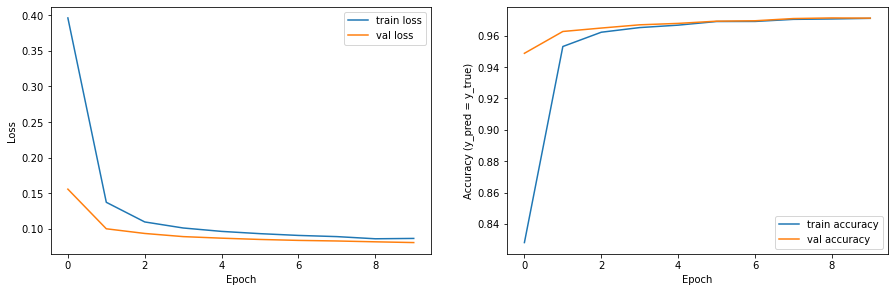

In [51]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [52]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

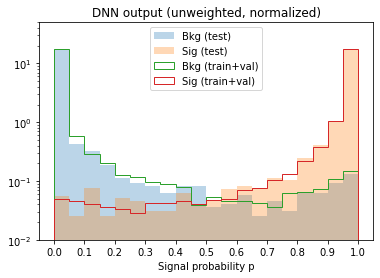

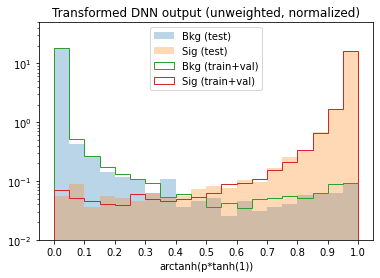

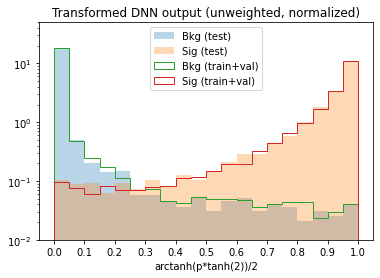

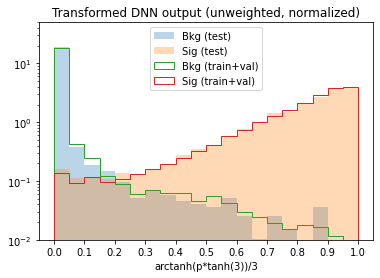

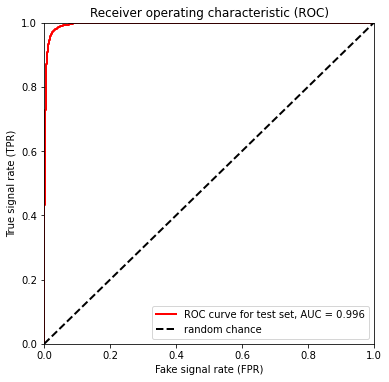

Test loss, test accuracy: [0.07544842794830194, 0.9741145968437195]


In [53]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Save trained model

In [54]:
joblib.dump(scaler, 'trained_models_rerunBtag/et1b_scaler.gz')
model.save('trained_models_rerunBtag/et1b_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models_rerunBtag/et1b_scaler.gz')
savedmodel = keras.models.load_model('trained_models_rerunBtag/et1b_model')
savedmodel.summary()

# Write model prediction to root files (NOW USE ANOTHER NOTEBOOK TO WRITE)

## Load all root files one by one

In [55]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/et18_raw/'
outfolder18 = 'root_outputs/et18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('etau_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/et17_raw/'
outfolder17 = 'root_outputs/et17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('etau_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/et16_raw/'
outfolder16 = 'root_outputs/et16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt15.root', 'gghbbtt20.root', 'gghbbtt25.root', 'gghbbtt30.root', 'gghbbtt35.root', 'gghbbtt40.root'\
         , 'gghbbtt45.root', 'gghbbtt50.root', 'gghbbtt55.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt15.root', 'vbfbbtt20.root', 'vbfbbtt25.root', 'vbfbbtt30.root', 'vbfbbtt35.root', 'vbfbbtt40.root'\
         , 'vbfbbtt45.root', 'vbfbbtt50.root', 'vbfbbtt55.root', 'vbfbbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('etau_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [56]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

root_raw/et18_raw/DY.root
root_raw/et18_raw/DY1.root
root_raw/et18_raw/DY2.root
root_raw/et18_raw/DY3.root
root_raw/et18_raw/DY4.root
root_raw/et18_raw/GGHTT.root
root_raw/et18_raw/GGHWW.root
root_raw/et18_raw/GGZHLLTT.root
root_raw/et18_raw/GGZHNNTT.root
root_raw/et18_raw/GGZHQQTT.root
root_raw/et18_raw/GGZHWW.root
root_raw/et18_raw/ST_tW_antitop.root
root_raw/et18_raw/ST_tW_top.root
root_raw/et18_raw/ST_t_antitop.root
root_raw/et18_raw/ST_t_top.root
root_raw/et18_raw/TTTo2L2Nu.root
root_raw/et18_raw/TTToHadronic.root
root_raw/et18_raw/TTToSemiLeptonic.root
root_raw/et18_raw/VBFHTT.root
root_raw/et18_raw/VBFHWW.root
root_raw/et18_raw/VV2L2Nu.root
root_raw/et18_raw/WZ2L2Q.root
root_raw/et18_raw/WZ3LNu.root
root_raw/et18_raw/WminusHTT.root
root_raw/et18_raw/WminusHWW.root
root_raw/et18_raw/WplusHTT.root
root_raw/et18_raw/WplusHWW.root
root_raw/et18_raw/ZHTT.root
root_raw/et18_raw/ZHWW.root
root_raw/et18_raw/ZZ2L2Q.root
root_raw/et18_raw/ZZ4L.root
root_raw/et18_raw/data_obs.root
root_raw

In [58]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

root_raw/et17_raw/DY.root
root_raw/et17_raw/DY1.root
root_raw/et17_raw/DY2.root
root_raw/et17_raw/DY3.root
root_raw/et17_raw/DY4.root
root_raw/et17_raw/GGHTT.root
root_raw/et17_raw/GGHWW.root
root_raw/et17_raw/GGZHLLTT.root
root_raw/et17_raw/GGZHNNTT.root
root_raw/et17_raw/GGZHQQTT.root
root_raw/et17_raw/GGZHWW.root
root_raw/et17_raw/ST_tW_antitop.root
root_raw/et17_raw/ST_tW_top.root
root_raw/et17_raw/ST_t_antitop.root
root_raw/et17_raw/ST_t_top.root
root_raw/et17_raw/TTTo2L2Nu.root
root_raw/et17_raw/TTToHadronic.root
root_raw/et17_raw/TTToSemiLeptonic.root
root_raw/et17_raw/VBFHTT.root
root_raw/et17_raw/VBFHWW.root
root_raw/et17_raw/VV2L2Nu.root
root_raw/et17_raw/WZ2L2Q.root
root_raw/et17_raw/WZ3L1Nu.root
root_raw/et17_raw/WminusHTT.root
root_raw/et17_raw/WminusHWW.root
root_raw/et17_raw/WplusHTT.root
root_raw/et17_raw/WplusHWW.root
root_raw/et17_raw/ZHTT.root
root_raw/et17_raw/ZHWW.root
root_raw/et17_raw/ZZ2L2Q.root
root_raw/et17_raw/ZZ4L.root
root_raw/et17_raw/data_obs.root
root_ra

In [60]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

root_raw/et16_raw/DY.root
root_raw/et16_raw/DY1.root
root_raw/et16_raw/DY2.root
root_raw/et16_raw/DY3.root
root_raw/et16_raw/DY4.root
root_raw/et16_raw/GGHTT.root
root_raw/et16_raw/GGHWW.root
root_raw/et16_raw/GGZHLLTT.root
root_raw/et16_raw/GGZHNNTT.root
root_raw/et16_raw/GGZHQQTT.root
root_raw/et16_raw/GGZHWW.root
root_raw/et16_raw/ST_tW_antitop.root
root_raw/et16_raw/ST_tW_top.root
root_raw/et16_raw/ST_t_antitop.root
root_raw/et16_raw/ST_t_top.root
root_raw/et16_raw/TT.root
root_raw/et16_raw/VBFHTT.root
root_raw/et16_raw/VBFHWW.root
root_raw/et16_raw/VV2L2Nu.root
root_raw/et16_raw/WZ2L2Q.root
root_raw/et16_raw/WZ3L1Nu.root
root_raw/et16_raw/WminusHTT.root
root_raw/et16_raw/WminusHWW.root
root_raw/et16_raw/WplusHTT.root
root_raw/et16_raw/WplusHWW.root
root_raw/et16_raw/ZHTT.root
root_raw/et16_raw/ZHWW.root
root_raw/et16_raw/ZZ2L2Q.root
root_raw/et16_raw/ZZ4L.root
root_raw/et16_raw/data_obs.root
root_raw/et16_raw/embedded.root
root_raw/et16_raw/ggH_bbtt15.root
root_raw/et16_raw/ggH_bb

## Feed to NN and write outputs to root files

In [57]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths18[i])

root_outputs/et18_outputs/DY.root
root_outputs/et18_outputs/DY1.root
root_outputs/et18_outputs/DY2.root
root_outputs/et18_outputs/DY3.root
root_outputs/et18_outputs/DY4.root
root_outputs/et18_outputs/GGHTT.root
root_outputs/et18_outputs/GGHWW.root
root_outputs/et18_outputs/GGZHLLTT.root
root_outputs/et18_outputs/GGZHNNTT.root
root_outputs/et18_outputs/GGZHQQTT.root
root_outputs/et18_outputs/GGZHWW.root
root_outputs/et18_outputs/ST_tW_antitop.root
root_outputs/et18_outputs/ST_tW_top.root
root_outputs/et18_outputs/ST_t_antitop.root
root_outputs/et18_outputs/ST_t_top.root
root_outputs/et18_outputs/TTTo2L2Nu.root
root_outputs/et18_outputs/TTToHadronic.root
root_outputs/et18_outputs/TTToSemiLeptonic.root
root_outputs/et18_outputs/VBFHTT.root
root_outputs/et18_outputs/VBFHWW.root
root_outputs/et18_outputs/VV2L2Nu.root
root_outputs/et18_outputs/WZ2L2Q.root
root_outputs/et18_outputs/WZ3LNu.root
root_outputs/et18_outputs/WminusHTT.root
root_outputs/et18_outputs/WminusHWW.root
root_outputs/et18_

In [59]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths17[i])

root_outputs/et17_outputs/DY.root
root_outputs/et17_outputs/DY1.root
root_outputs/et17_outputs/DY2.root
root_outputs/et17_outputs/DY3.root
root_outputs/et17_outputs/DY4.root
root_outputs/et17_outputs/GGHTT.root
root_outputs/et17_outputs/GGHWW.root
root_outputs/et17_outputs/GGZHLLTT.root
root_outputs/et17_outputs/GGZHNNTT.root
root_outputs/et17_outputs/GGZHQQTT.root
root_outputs/et17_outputs/GGZHWW.root
root_outputs/et17_outputs/ST_tW_antitop.root
root_outputs/et17_outputs/ST_tW_top.root
root_outputs/et17_outputs/ST_t_antitop.root
root_outputs/et17_outputs/ST_t_top.root
root_outputs/et17_outputs/TTTo2L2Nu.root
root_outputs/et17_outputs/TTToHadronic.root
root_outputs/et17_outputs/TTToSemiLeptonic.root
root_outputs/et17_outputs/VBFHTT.root
root_outputs/et17_outputs/VBFHWW.root
root_outputs/et17_outputs/VV2L2Nu.root
root_outputs/et17_outputs/WZ2L2Q.root
root_outputs/et17_outputs/WZ3L1Nu.root
root_outputs/et17_outputs/WminusHTT.root
root_outputs/et17_outputs/WminusHWW.root
root_outputs/et17

In [61]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths16[i])

root_outputs/et16_outputs/DY.root
root_outputs/et16_outputs/DY1.root
root_outputs/et16_outputs/DY2.root
root_outputs/et16_outputs/DY3.root
root_outputs/et16_outputs/DY4.root
root_outputs/et16_outputs/GGHTT.root
root_outputs/et16_outputs/GGHWW.root
root_outputs/et16_outputs/GGZHLLTT.root
root_outputs/et16_outputs/GGZHNNTT.root
root_outputs/et16_outputs/GGZHQQTT.root
root_outputs/et16_outputs/GGZHWW.root
root_outputs/et16_outputs/ST_tW_antitop.root
root_outputs/et16_outputs/ST_tW_top.root
root_outputs/et16_outputs/ST_t_antitop.root
root_outputs/et16_outputs/ST_t_top.root
root_outputs/et16_outputs/TT.root
root_outputs/et16_outputs/VBFHTT.root
root_outputs/et16_outputs/VBFHWW.root
root_outputs/et16_outputs/VV2L2Nu.root
root_outputs/et16_outputs/WZ2L2Q.root
root_outputs/et16_outputs/WZ3L1Nu.root
root_outputs/et16_outputs/WminusHTT.root
root_outputs/et16_outputs/WminusHWW.root
root_outputs/et16_outputs/WplusHTT.root
root_outputs/et16_outputs/WplusHWW.root
root_outputs/et16_outputs/ZHTT.root
